In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from scipy import stats
import json
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

warnings.filterwarnings("ignore")

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv


In [2]:
dir_train = "/kaggle/input/tmdb-box-office-prediction/train.csv"
dir_test = "/kaggle/input/tmdb-box-office-prediction/test.csv"

In [3]:
df_train = pd.read_csv(dir_train)
df_test = pd.read_csv(dir_test)

In [4]:
df_train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [5]:
df_test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [6]:
df_train["data"] = "train"
df_test["data"] = "test"

In [7]:
df_test["revenue"] = np.nan

In [8]:
df_train.shape, df_test.shape

((3000, 24), (4398, 24))

In [9]:
df = pd.concat([df_train, df_test], axis = 0)

In [10]:
df.shape

(7398, 24)

In [11]:
df.columns = df.columns.str.lower()

In [12]:
starting_cols = df_train.columns

# Utils

In [13]:
def get_dictionary(string):
    try:
        result = eval(string)
    except:
        result = {}
    return result

# EDA 

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

There are 3 feature which is int type, 2 feature which is float and rest of them type is object.

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

## revenue feature

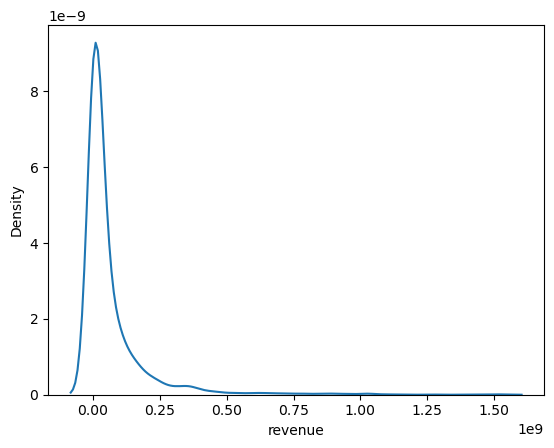

In [16]:
sns.kdeplot(df[df["data"] == "train"].revenue)
plt.show()

In [17]:
df["log_revenue"] = np.log1p(df["revenue"])

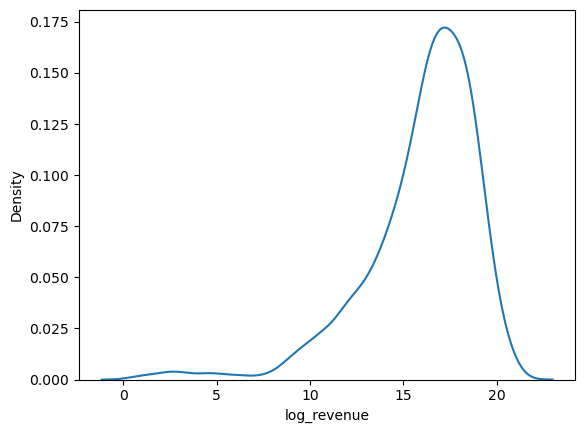

In [18]:
sns.kdeplot(df[df["data"] == "train"].log_revenue)
plt.show()

log transformation of revenue feature works to converged to normal distribution.

## belongs_to_collection feature

Some movies has collection but some of them not. We are gonna create feature as a indicator which has movie collection or not

In [19]:
df["is_have_collection"] = df["belongs_to_collection"].apply(lambda x: 1 if get_dictionary(x) != {} else 0)

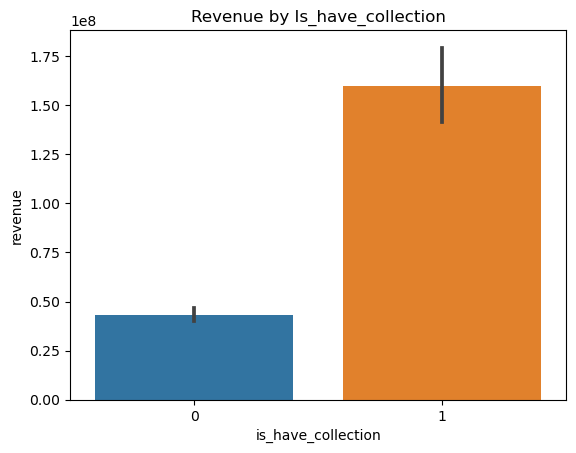

In [20]:
sns.barplot(data = df[df["data"] == "train"], x = "is_have_collection", y = "revenue")
plt.title("Revenue by Is_have_collection")
plt.show()

As we see, it is important that if movies has collection

In [21]:
df = df.drop("belongs_to_collection", axis = 1)

## homepage feature

Some movies has homepage but some of them not. We are gonan create feature using this knowledge

In [22]:
df["homepage"].head()

0                                  NaN
1                                  NaN
2    http://sonyclassics.com/whiplash/
3           http://kahaanithefilm.com/
4                                  NaN
Name: homepage, dtype: object

In [23]:
df["is_have_homepage"] = df["homepage"].apply(lambda x: 1 if "http" in str(x) else 0)

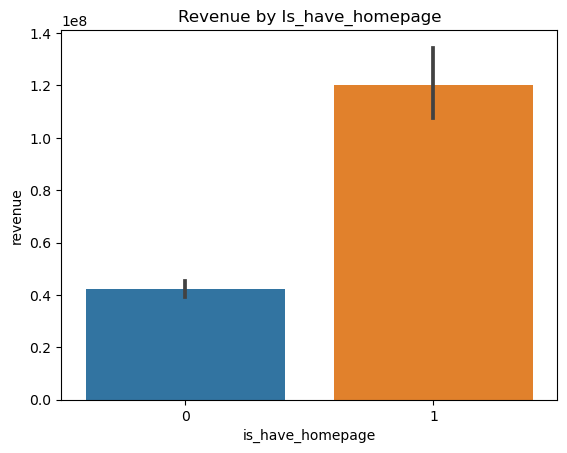

In [24]:
sns.barplot(data = df[df["data"] == "train"], x = "is_have_homepage", y = "revenue")
plt.title("Revenue by Is_have_homepage")
plt.show()

It seems important for a movie to have a homepage.

In [25]:
df = df.drop("homepage", axis = 1)

## genres feature

In [26]:
df[df["data"] == "train"]["genres"].head()

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

We should extract genres_name as a movie category. Firstly we should delete NaN values to this feature

In [27]:
df["genres"] =  df["genres"].map(lambda x: sorted([d["name"] for d in get_dictionary(x)])).map(lambda x: ",".join(map(str,x)))
genres = df["genres"].str.get_dummies(sep  = ",")
df = pd.concat([df, genres], axis = 1, sort = False)

In [28]:
df.shape

(7398, 45)

Columns number increased, so it did work succesfully

In [29]:
df = df.drop("genres", axis = 1)

## imdb_id feature

In [30]:
df[df["data"] == "train"]["imdb_id"].head()

0    tt2637294
1    tt0368933
2    tt2582802
3    tt1821480
4    tt1380152
Name: imdb_id, dtype: object

This feature seems like unnecessary.

In [31]:
df = df.drop("imdb_id", axis = 1)

## original_language

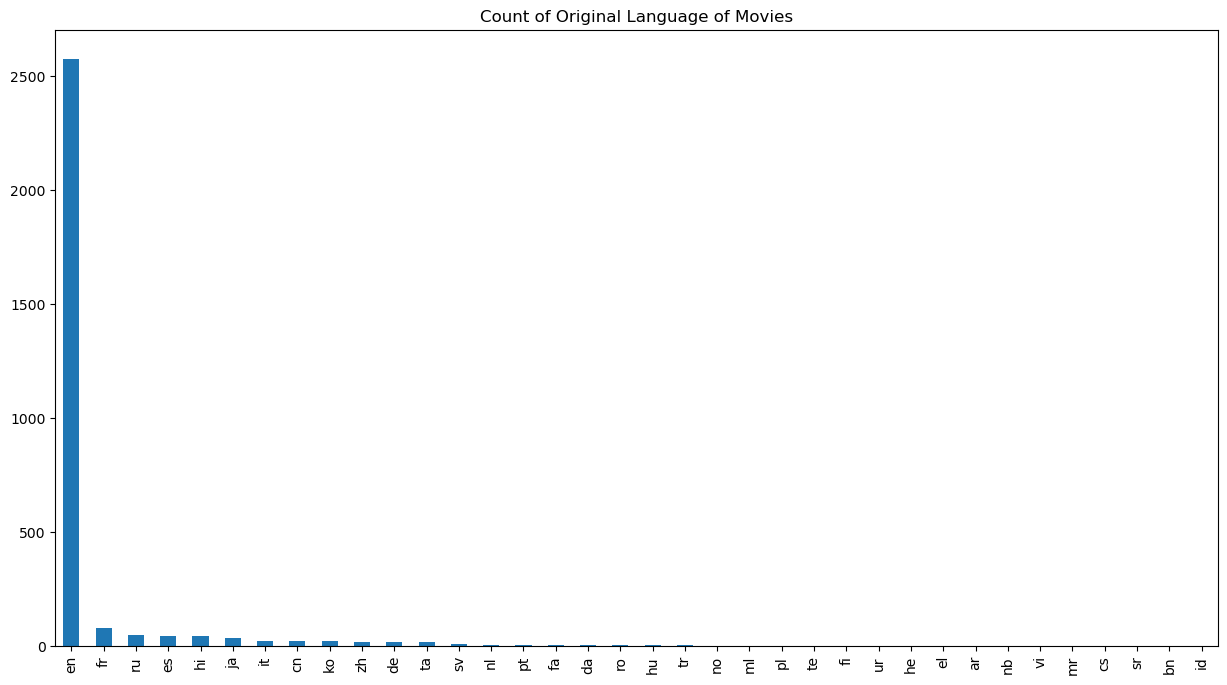

In [32]:
plt.figure(figsize = (15,8))
df[df["data"] == "train"]["original_language"].value_counts().plot(kind="bar")
plt.title("Count of Original Language of Movies")
plt.show()

Most of movies language is English as expected. We are gonna convert that type of feature.  

In [33]:
label_encoder = LabelEncoder()

In [34]:
df["original_language"] = label_encoder.fit_transform(df["original_language"])

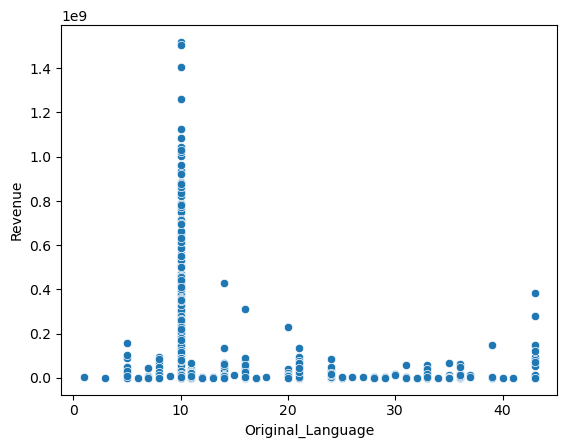

In [35]:
sns.scatterplot(x = "original_language", y = "revenue", data = df[df["data"] == "train"])
plt.xlabel("Original_Language")
plt.ylabel("Revenue")
plt.show()

## poster_path feature

In [36]:
df[df["data"] == "train"]["poster_path"].head()

0    /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
1    /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
2    /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg
3    /aTXRaPrWSinhcmCrcfJK17urp3F.jpg
4    /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg
Name: poster_path, dtype: object

This feature seems like irrelevant. So we are gonna add this feature to drop list

In [37]:
df = df.drop("poster_path", axis = 1)

### original_title feature

In [38]:
df[df["data"] == "train"]["original_title"].head()

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                        마린보이
Name: original_title, dtype: object

In [39]:
len(df[df["data"] == "train"]["original_title"].unique()), df[df["data"] == "train"]["original_title"].shape[0]

(2975, 3000)

There are 25 movies which has same title. This can be movies which produced second or third times. This feature seems like unnecessary, so we can add this feature to drop list

In [40]:
df = df.drop("original_title", axis = 1)

### popularity feature

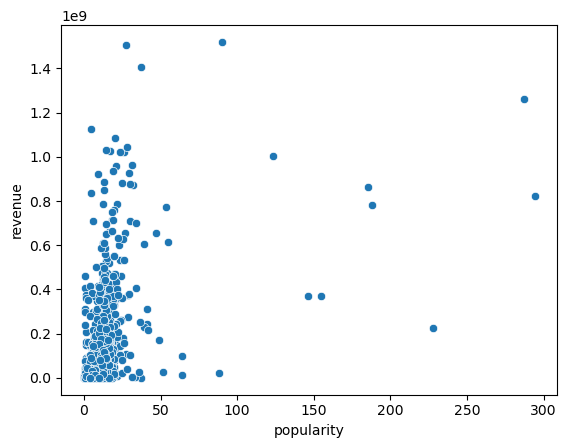

In [41]:
sns.scatterplot(x = "popularity", y = "revenue", data = df[df["data"] == "train"])
plt.show()

Mostly, popularity is between 0 to 50.

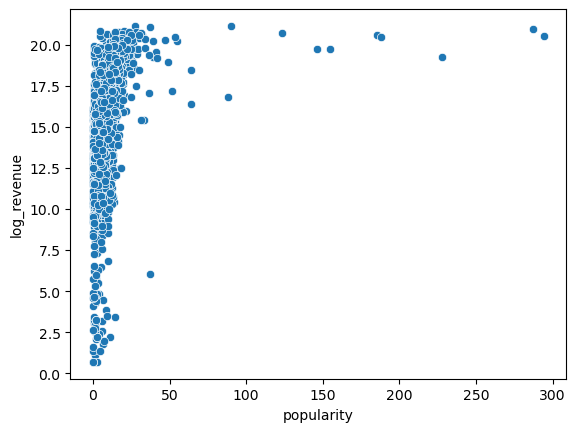

In [42]:
sns.scatterplot(x = "popularity", y = "log_revenue", data = df[df["data"] == "train"])
plt.show()

## production_companies feature

This feature has 149 NaN values in train dataset, and 258 NaN values in test set.

In [43]:
df[df["data"] == "train"]["production_companies"].head()

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                  NaN
4                                                  NaN
Name: production_companies, dtype: object

We can extract production companies' name and we can doing one hot encoding process to extract useful information

In [44]:
list_of_companies = list(df['production_companies']. \
                         apply(lambda x: [i['name'] for i in get_dictionary(x)] if x != {} \
                               else []).values)

In [45]:
element_frequencies = Counter([i for j in list_of_companies for i in j]).most_common()

In [46]:
element_frequencies[:10]

[('Warner Bros.', 491),
 ('Universal Pictures', 463),
 ('Paramount Pictures', 393),
 ('Twentieth Century Fox Film Corporation', 341),
 ('Columbia Pictures', 236),
 ('Metro-Goldwyn-Mayer (MGM)', 207),
 ('New Line Cinema', 198),
 ('Touchstone Pictures', 158),
 ('Walt Disney Pictures', 147),
 ('Columbia Pictures Corporation', 140)]

In [47]:
df["production_companies"] = df["production_companies"]. \
                                    map(lambda x: [i["name"] for i in get_dictionary(x)]). \
                                    map(lambda x: ",".join(map(str,x)))

In [48]:
df["mean_production_company_frequencies"] = df["production_companies"]. \
                apply(lambda x: np.mean([count for element, count in element_frequencies if element in x]) \
                      if x != "" else 0)

In [49]:
df["mean_production_company_frequencies"].head()

0    141.8
1     52.0
2     11.5
3      0.0
4      0.0
Name: mean_production_company_frequencies, dtype: float64

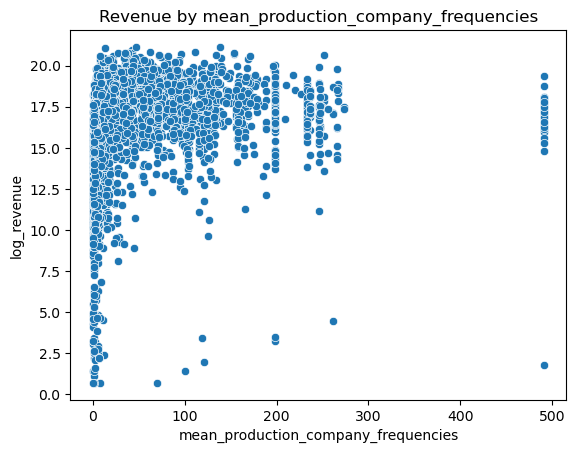

In [50]:
sns.scatterplot(x = "mean_production_company_frequencies", y = "log_revenue", data = df[df["data"] == "train"])
plt.title("Revenue by mean_production_company_frequencies")
plt.show()

In [51]:
df.shape

(7398, 42)

Columns feature has increased, so it did work succesfully.

In [52]:
df = df.drop("production_companies", axis = 1)

## production_countries feature

In [53]:
df[df["data"] == "train"]["production_countries"].head()

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3              [{'iso_3166_1': 'IN', 'name': 'India'}]
4        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
Name: production_countries, dtype: object

We should extract production country name and we can use this information

In [54]:
list_of_countries = list(df['production_countries']. \
                         apply(lambda x: [i['name'] for i in get_dictionary(x)] if x != {} \
                               else []).values)

In [55]:
element_frequencies_country = Counter([i for j in list_of_countries for i in j]).most_common()

In [56]:
element_frequencies_country[:10]

[('United States of America', 5617),
 ('United Kingdom', 917),
 ('France', 570),
 ('Germany', 411),
 ('Canada', 323),
 ('India', 220),
 ('Italy', 160),
 ('Japan', 157),
 ('Australia', 148),
 ('Spain', 139)]

In [57]:
df["production_countries"] = df["production_countries"]. \
                                    map(lambda x: [i["name"] for i in get_dictionary(x)]). \
                                    map(lambda x: ",".join(map(str,x)))

In [58]:
df["mean_production_country_frequencies"] = df["production_countries"]. \
                apply(lambda x: np.mean([count for element, count in element_frequencies_country if element in x]) \
                      if x != "" else 0)

In [59]:
df["mean_production_country_frequencies"].head()

0    5617.0
1    5617.0
2    5617.0
3     220.0
4      58.0
Name: mean_production_country_frequencies, dtype: float64

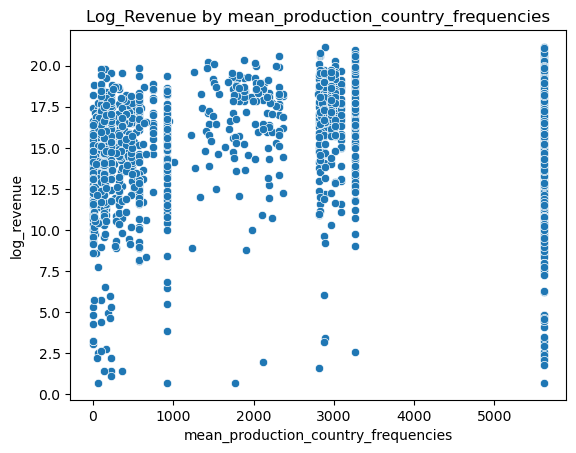

In [60]:
sns.scatterplot(x = "mean_production_country_frequencies", y = "log_revenue", data = df[df["data"] == "train"])
plt.title("Log_Revenue by mean_production_country_frequencies")
plt.show()

In [61]:
#df["production_countries"] = df["production_countries"].map(lambda x: [i["name"] for i in get_dictionary(x)]) \
#                                                        .map(lambda x: ",".join(map(str, x)))
#production_countries = df["production_countries"].str.get_dummies(sep  =",")
#df = pd.concat([df, production_countries], axis = 1)
                                                                

In [62]:
df.shape

(7398, 42)

In [63]:
df = df.drop("production_countries", axis = 1)

## release_date feature

In [64]:
df["release_date"].head()

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

We can extract useful information with using this feature. For example, year, month, day, day of week.

In [65]:
def fix_dates(dates):
    try:
        year = str(dates).split("/")[2]
        if int(year) <= 19:
            date = dates[:-2] + "20" + year
        else:
            date = dates[:-2] + "19" + year
    except:
        date = np.nan
    return date

In [66]:
df["release_date"] = df["release_date"].apply(fix_dates)

In [67]:
df["release_date"].head()

0     2/20/2015
1      8/6/2004
2    10/10/2014
3      3/9/2012
4      2/5/2009
Name: release_date, dtype: object

In [68]:
# Convert data type to datetime
df["release_date"] = pd.to_datetime(df["release_date"])

In [69]:
df["release_date"].info()

<class 'pandas.core.series.Series'>
Int64Index: 7398 entries, 0 to 4397
Series name: release_date
Non-Null Count  Dtype         
--------------  -----         
7397 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 115.6 KB


There is one row with NaN values on release_date feature. I am gonna delete this row

In [70]:
def datetime_features(dataframe):
    dataframe["month"] = dataframe["release_date"].dt.month
    dataframe["year"] = dataframe["release_date"].dt.year
    dataframe["day"] = dataframe["release_date"].dt.day
    dataframe["dayofweek"] = dataframe["release_date"].dt.dayofweek
    dataframe["quarter"] = dataframe["release_date"].dt.quarter
    dataframe["weekofyear"] = dataframe["release_date"].dt.weekofyear
    return dataframe

In [71]:
df = datetime_features(df)

In [72]:
def draw_boxplot(dataframe, col):
    plt.figure(figsize = (15,6))
    sns.boxplot(data = dataframe, x = col, y = "log_revenue")
    plt.xlabel(col)
    plt.ylabel("log_revenue")
    plt.title(f"Log of Revenue by {col}")
    plt.show()

### month feature

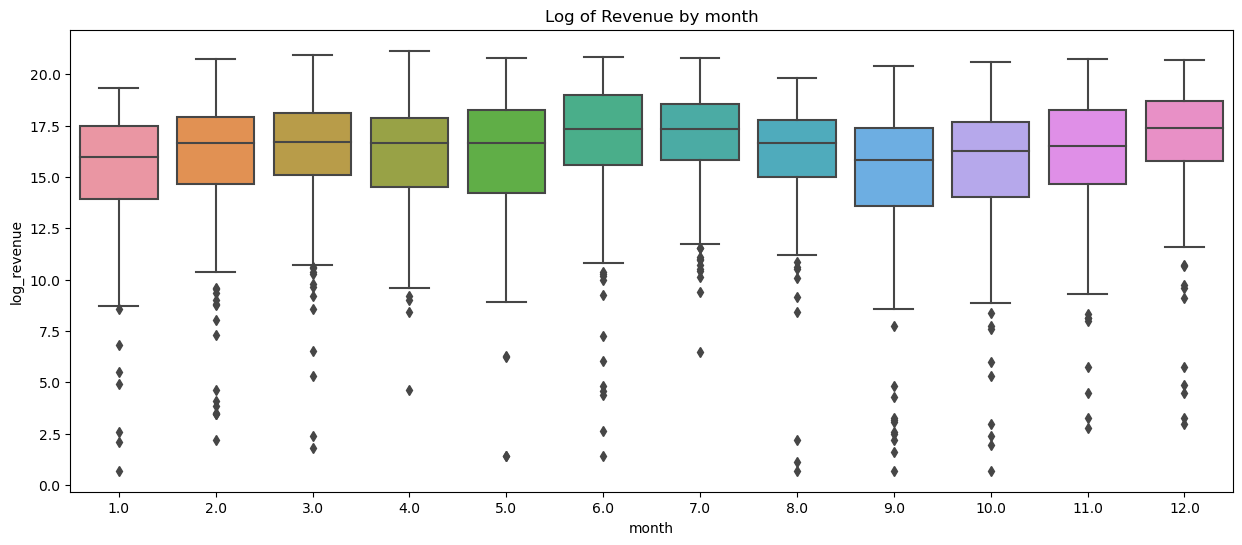

In [73]:
draw_boxplot(df[df["data"] == "train"], "month")

Movies which produced in June, July and December brings more revenue. Movies which produced in January and September brings less revenue.

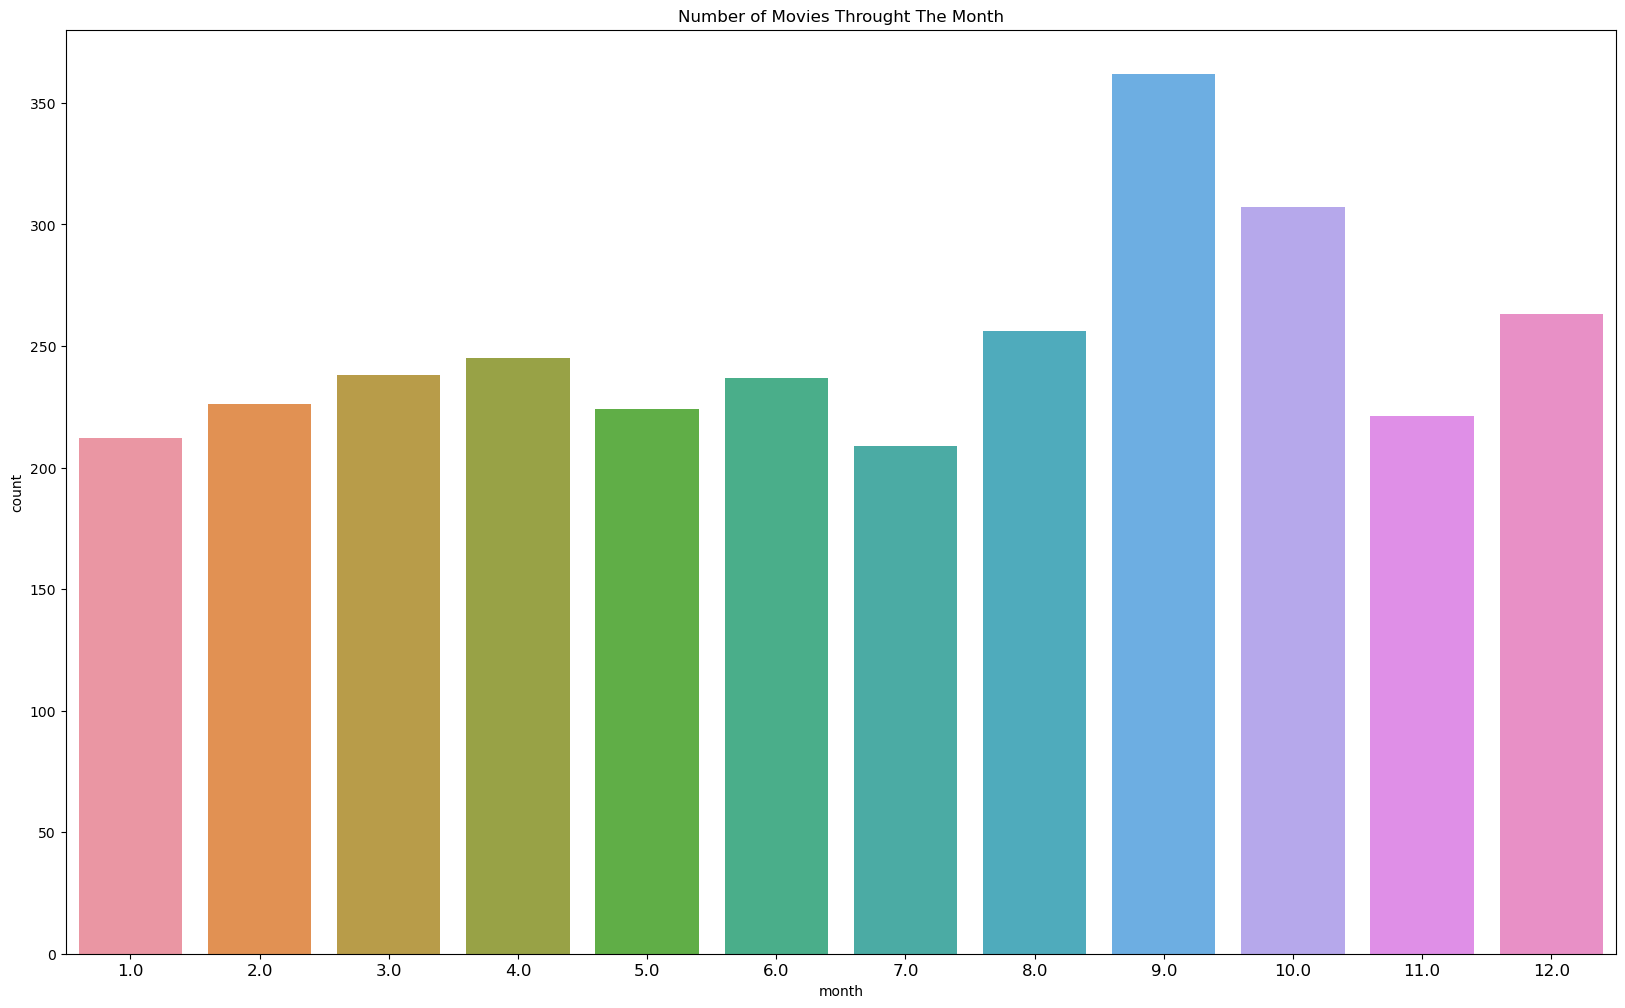

In [74]:
plt.figure(figsize = (20,12))
sns.countplot(x = df[df["data"] == "train"]["month"].sort_values())
plt.title("Number of Movies Throught The Month")
loc, labels = plt.xticks()
plt.xticks(fontsize=12,rotation=0)
plt.show()

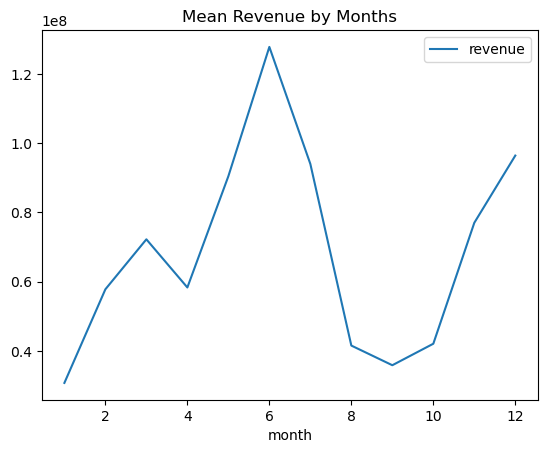

In [75]:
df[df["data"] == "train"][["month", "revenue"]].groupby(by = "month").mean().plot()
plt.title("Mean Revenue by Months")
plt.show()

Seems like a there is a seasonal effect when we calculate mean revenue by months

In [76]:
# Seasonal features by month
df['month_sin'] = np.sin(2*np.pi*df.month/12)
df['month_cos'] = np.cos(2*np.pi*df.month/12)

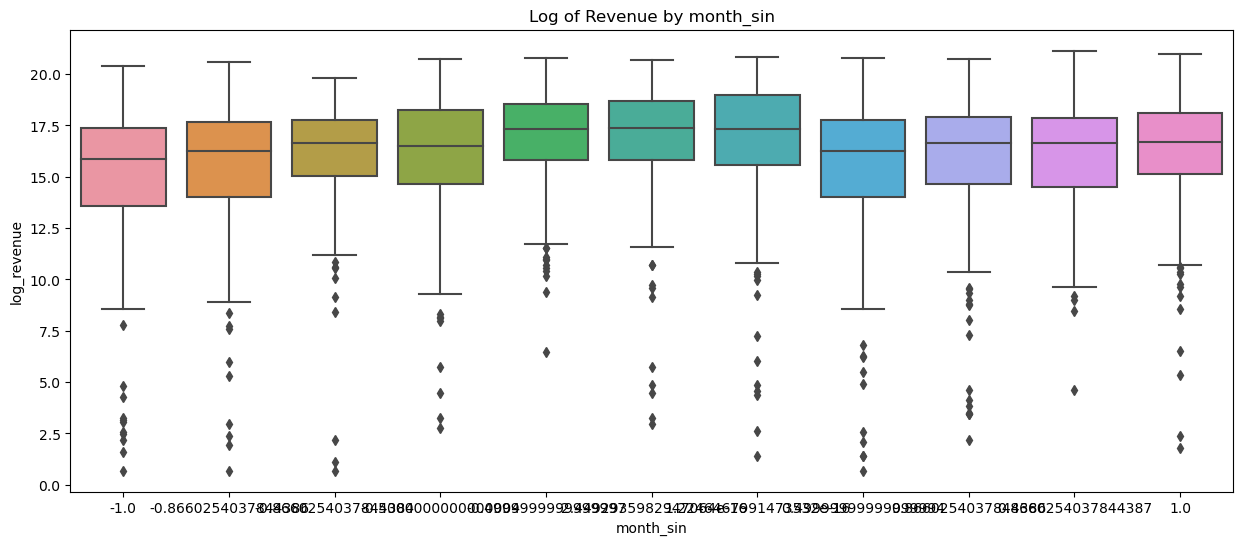

In [77]:
draw_boxplot(df[df["data"] == "train"], "month_sin")

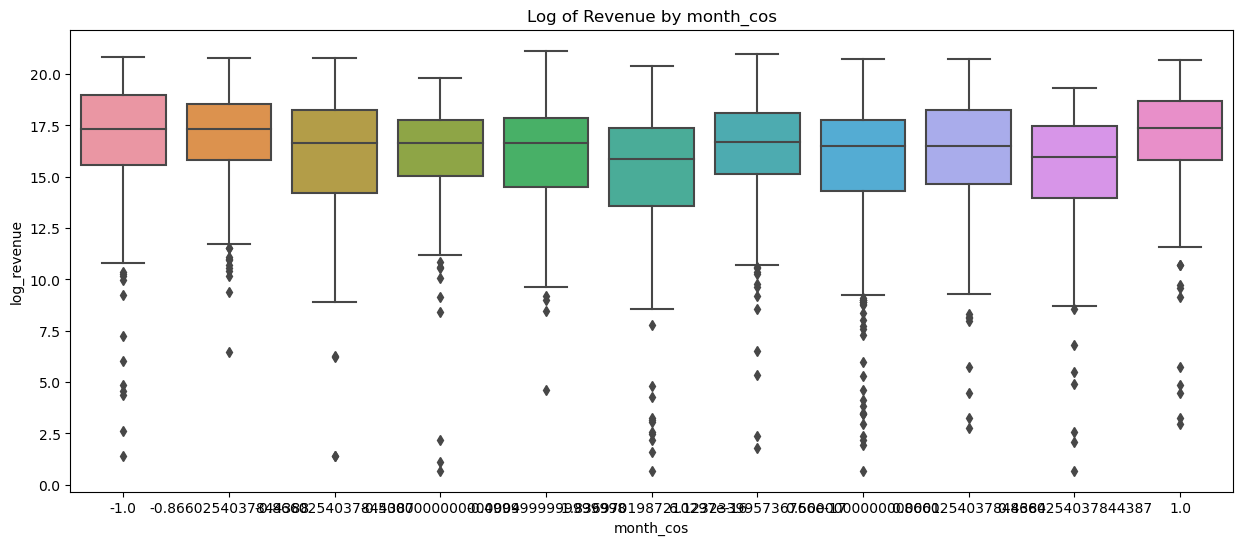

In [78]:
draw_boxplot(df[df["data"] == "train"], "month_cos")

### year feature

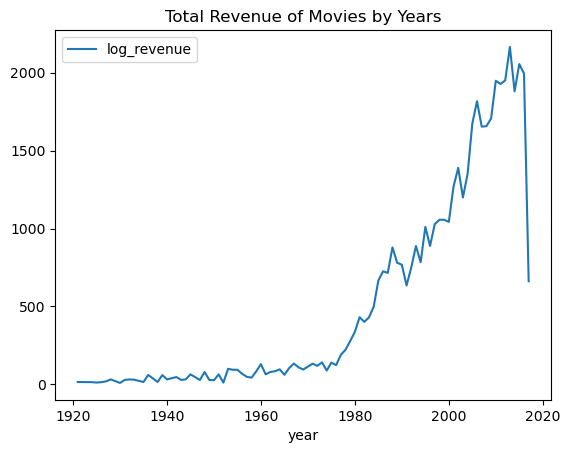

In [79]:
df.loc[df["data"] == "train", ["year", "log_revenue"]].groupby(by = "year", group_keys = True).sum().plot()
plt.title("Total Revenue of Movies by Years")
plt.show()

As we get closer to the present, the total revenue from movies increases throughout the year. But revenue have decreased on last year

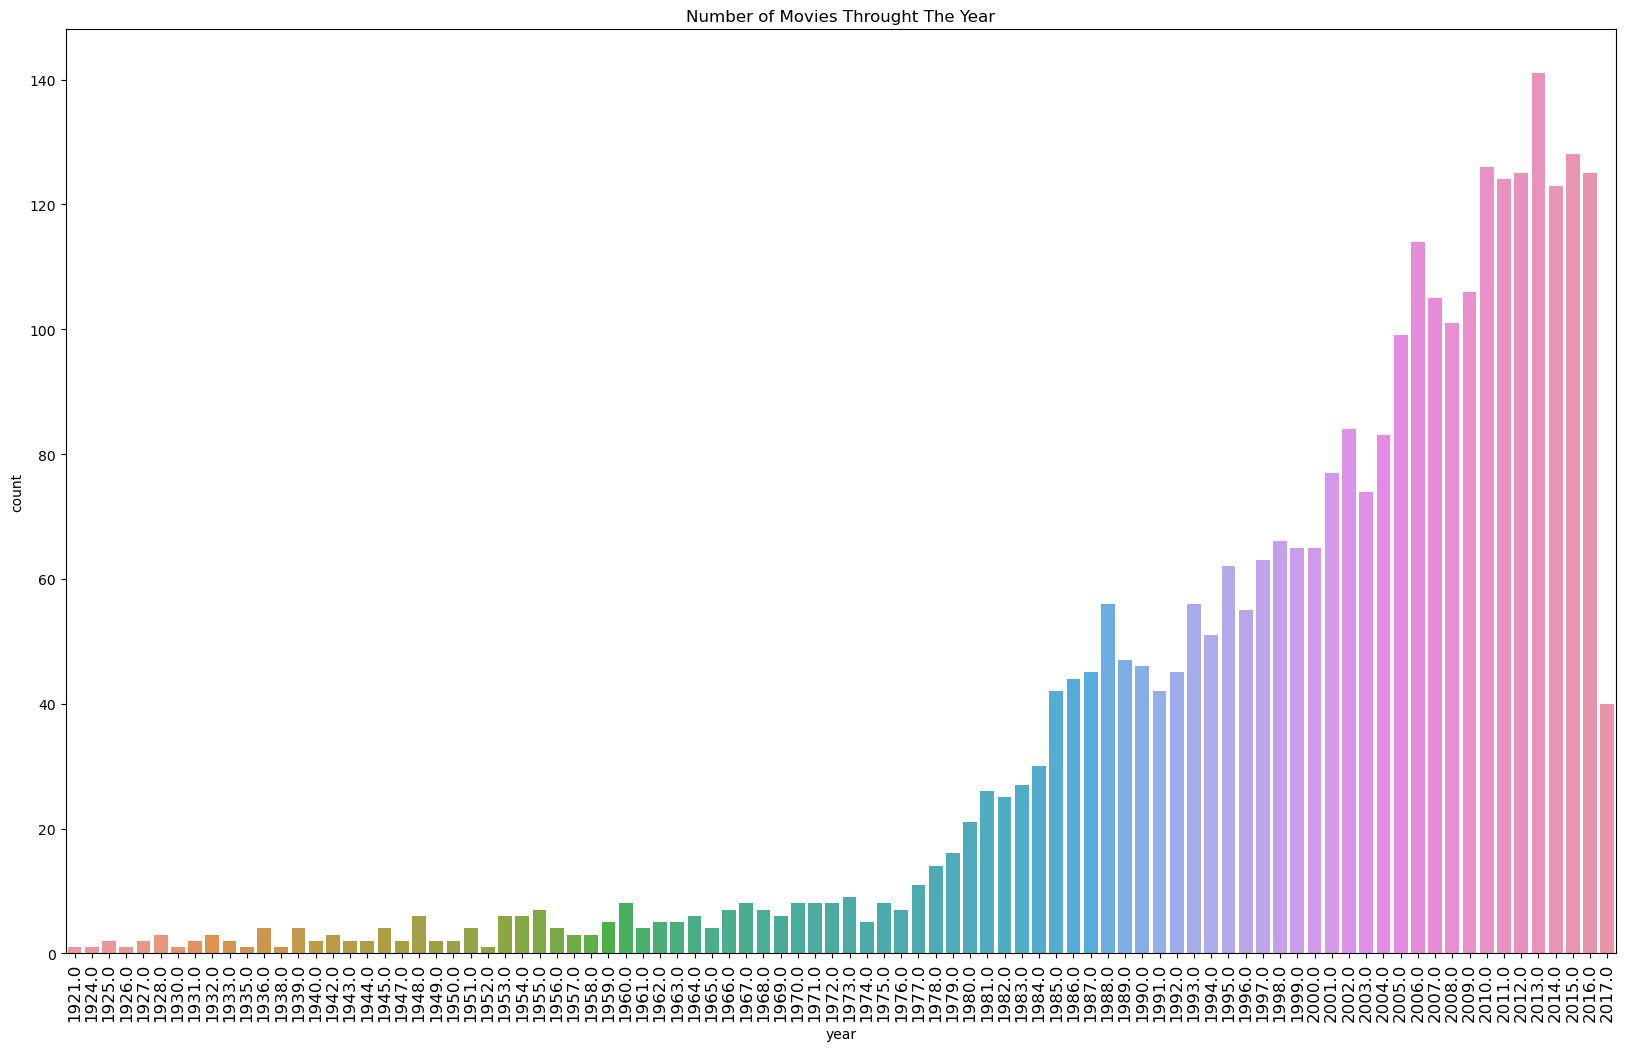

In [80]:
plt.figure(figsize = (20,12))
sns.countplot(x = df[df["data"] == "train"]["year"].sort_values())
plt.title("Number of Movies Throught The Year")
loc, labels = plt.xticks()
plt.xticks(fontsize=12,rotation=90)
plt.show()

As we get closer to the present, the total count of movies increases throughout the year.

### dayofweek feature

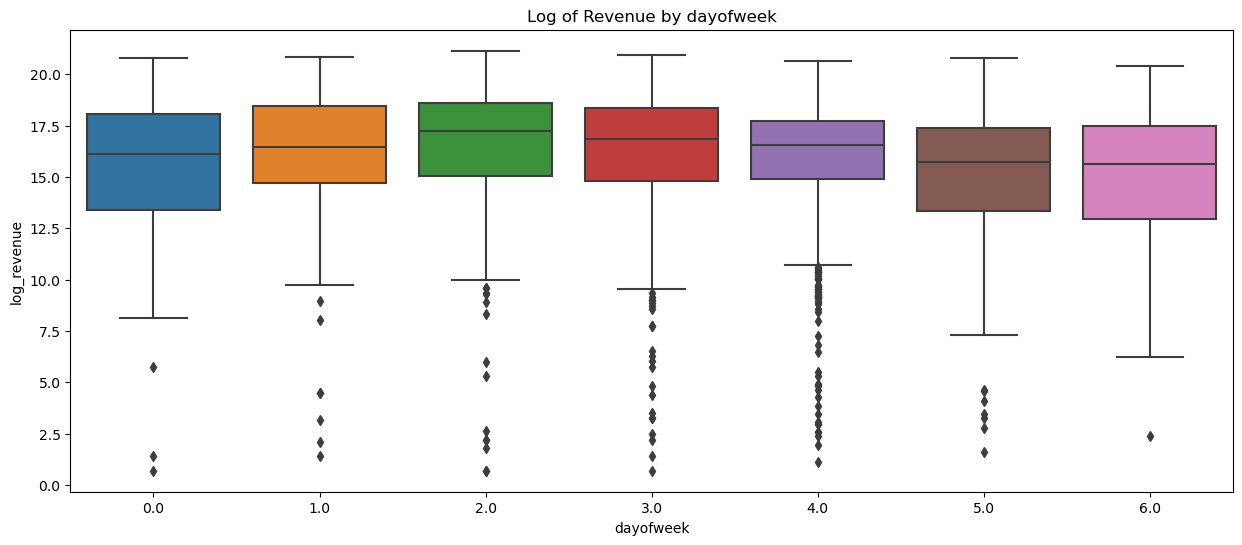

In [81]:
draw_boxplot(df[df["data"] == "train"], "dayofweek")

Movies which released on Tuesday, Wednesday and Thursday have higher revenue than other movies.

In [82]:
df["is_weekday_TWT"] = df["dayofweek"].apply(lambda x: 1 if x in [2, 3, 4] else 0)

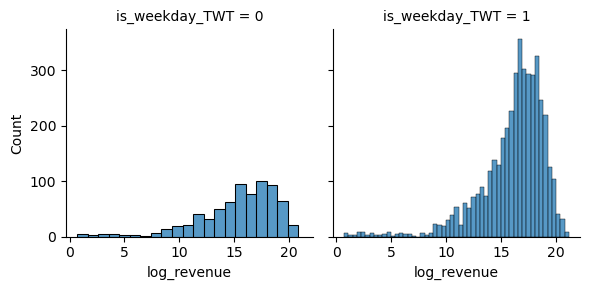

In [83]:
grid = sns.FacetGrid(data = df, col = "is_weekday_TWT")
grid.map(sns.histplot, "log_revenue")
plt.show()

As we see, is_weekday_TWT feature has really impact on log_revenue

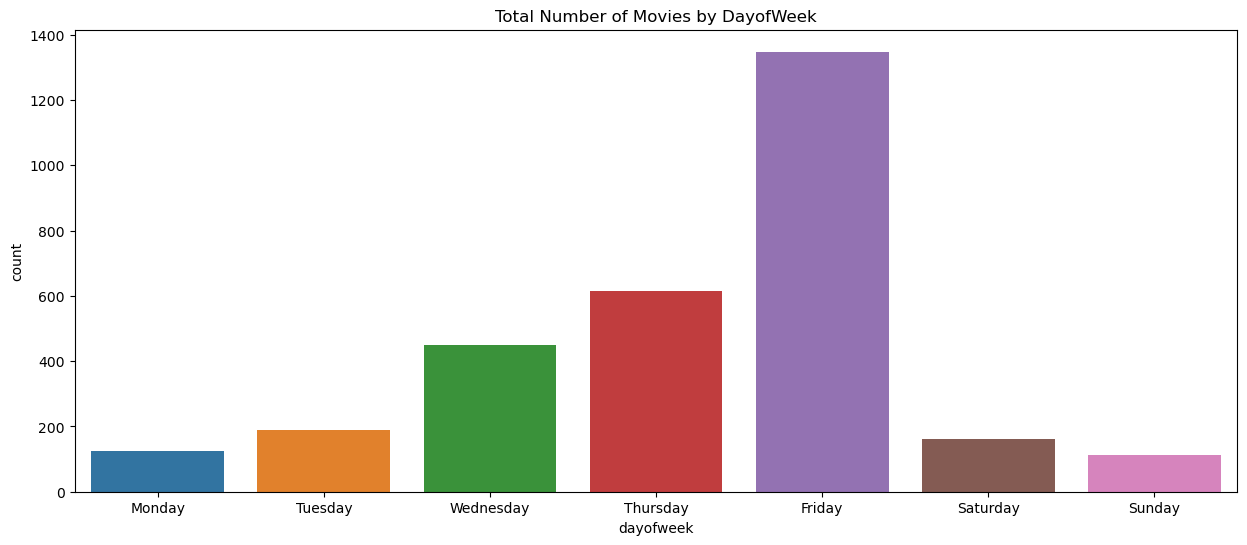

In [84]:
plt.figure(figsize = (15,6))
sns.countplot(x = df[df["data"] == "train"].dayofweek)
loc, labels = plt.xticks()
loc, labels = loc, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.xticks(loc, labels, fontsize = 10)
plt.title("Total Number of Movies by DayofWeek")
plt.show()

Most of movies released on Friday. Count of movies which released on Saturday, Sunday and Monday is relatively few.

### quarter feature

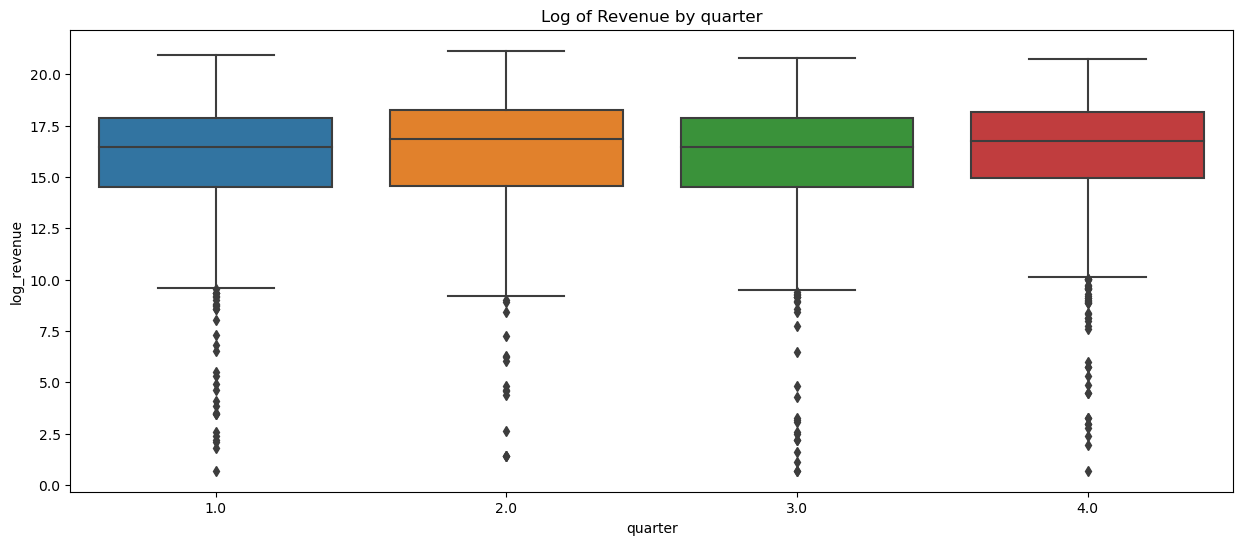

In [85]:
draw_boxplot(df[df["data"] == "train"], "quarter")

In this graph, first quarter cover January, February and March and last quarter cover October, November and December.There was an increase in revenues in the second quarter compared to the first quarter. But There was a decrease in revenues in the third quarter compared to the second quarter and there was an increase in revenues in the fourth quarter compared to the third quarter. Seems like there is a seasonal effect on revenue.

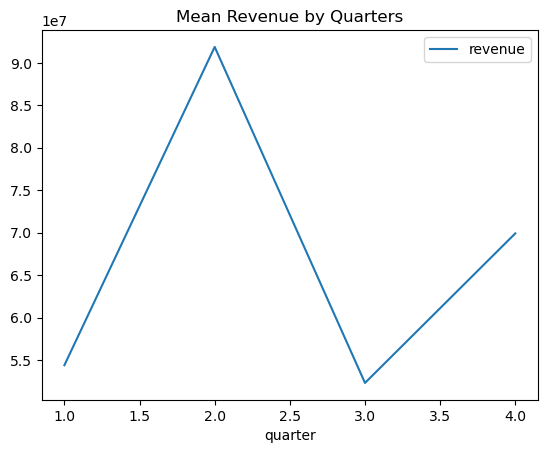

In [86]:
df[df["data"] == "train"][["quarter", "revenue"]].groupby(by = "quarter").mean().plot()
plt.title("Mean Revenue by Quarters")
plt.show()

In [87]:
# Seasonal features by month
df['quarter_sin'] = np.sin(2*np.pi*df.quarter/4)
df['quarter_cos'] = np.cos(2*np.pi*df.quarter/4)

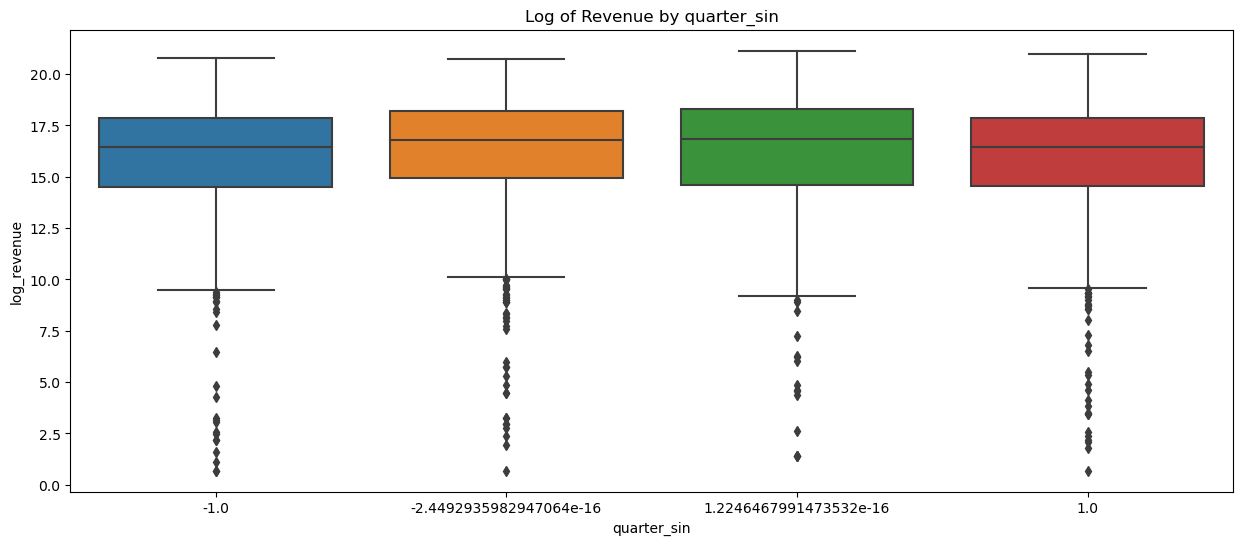

In [88]:
draw_boxplot(df[df["data"] == "train"], "quarter_sin")

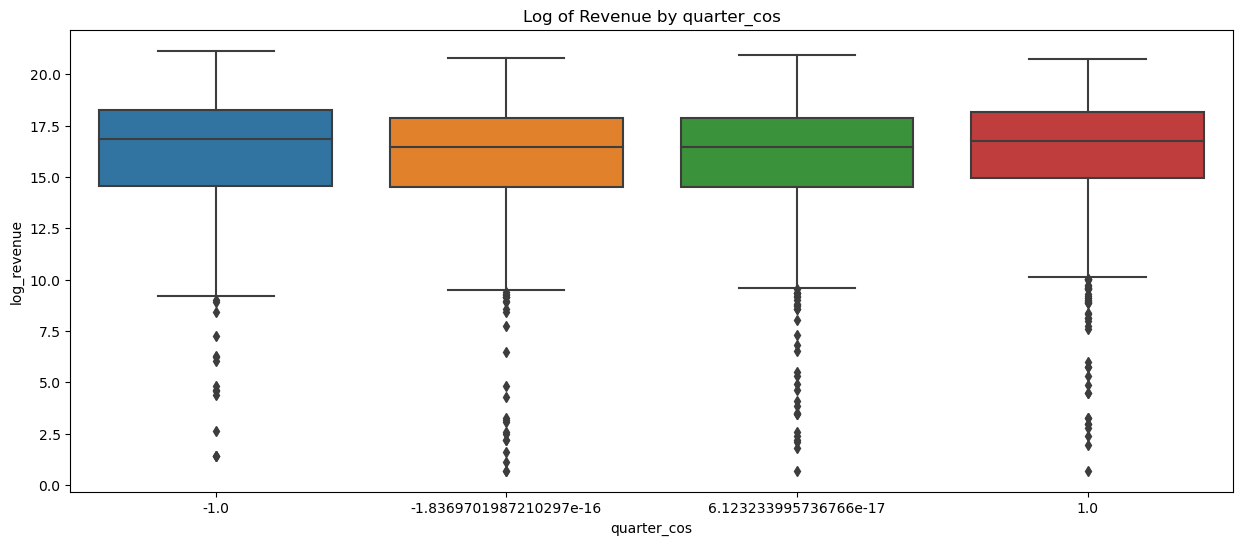

In [89]:
draw_boxplot(df[df["data"] == "train"], "quarter_cos")

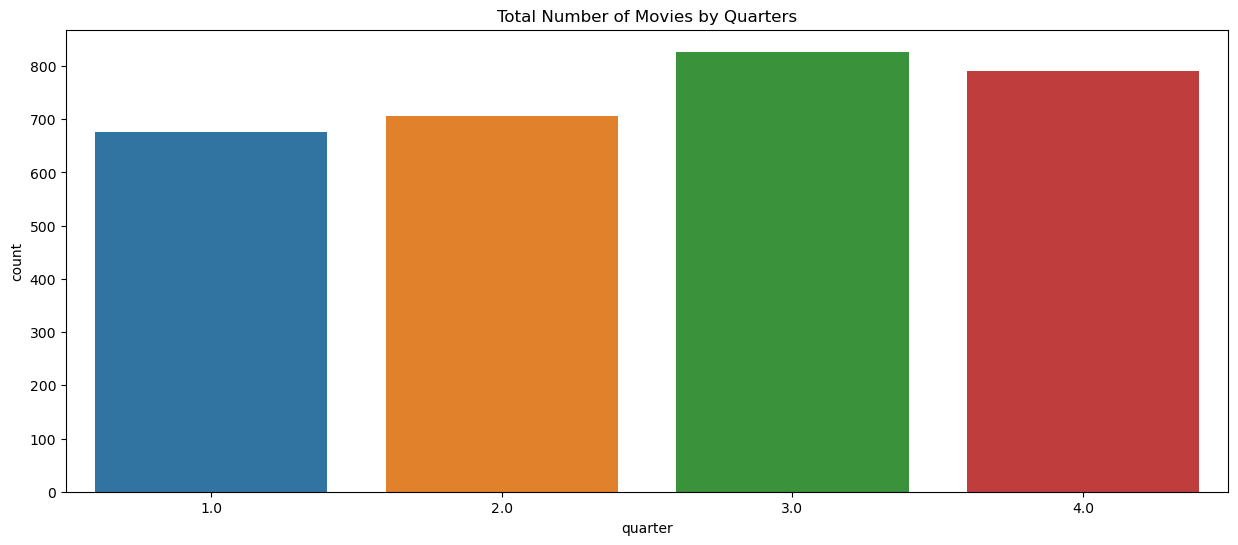

In [90]:
plt.figure(figsize = (15,6))
sns.countplot(x = df[df["data"] == "train"].quarter)
plt.title("Total Number of Movies by Quarters")
plt.show()

Count of movies which released on 3 and 4 quarter are relatively much higher than other two quarters

### day feature

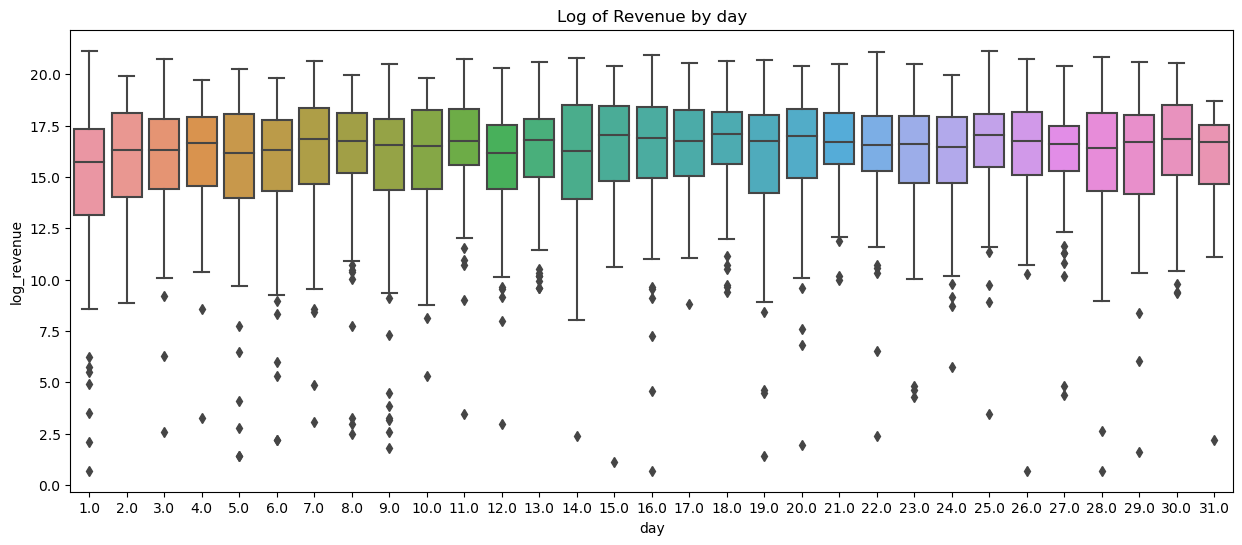

In [91]:
draw_boxplot(df[df["data"] == "train"], "day")

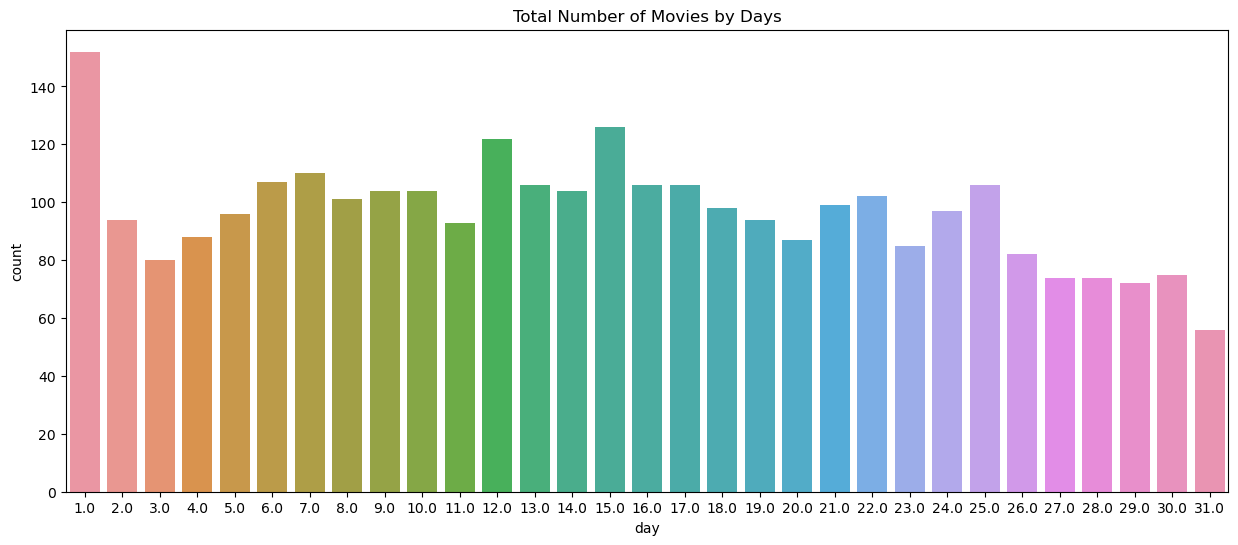

In [92]:
plt.figure(figsize = (15,6))
sns.countplot(x = df[df["data"] == "train"].day)
plt.title("Total Number of Movies by Days")
plt.show()

Count of movies which released on first day of months are higher than others. Producers must be choosing the first day of the month to release movie.

### weekofyear feature

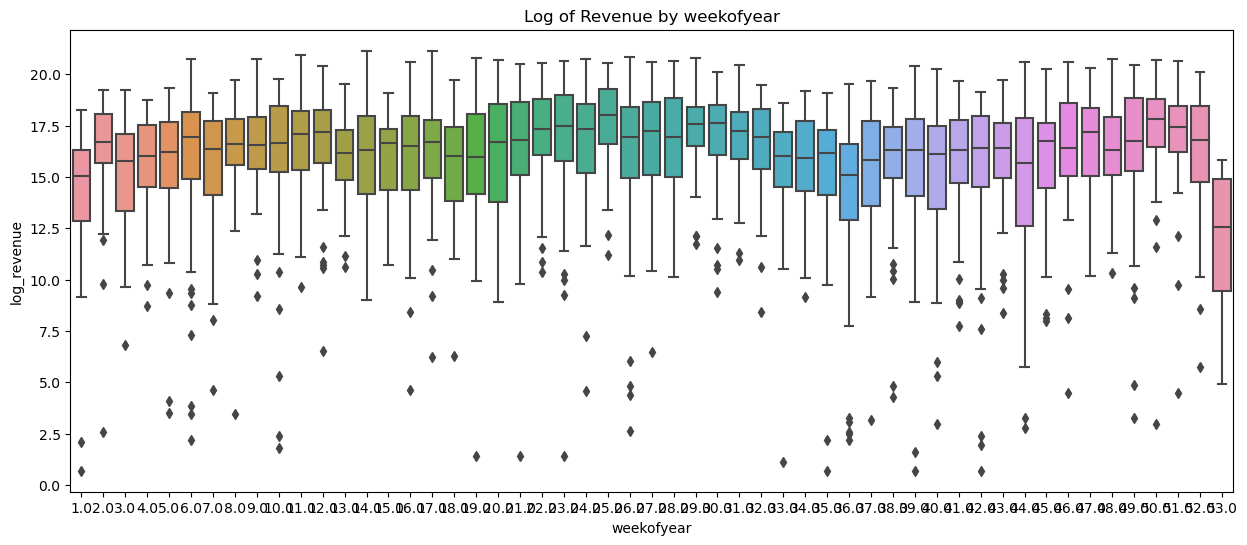

In [93]:
draw_boxplot(df[df["data"] == "train"], "weekofyear")

In [94]:
df = df.drop(["release_date", "dayofweek"], axis = 1)

## runtime feature

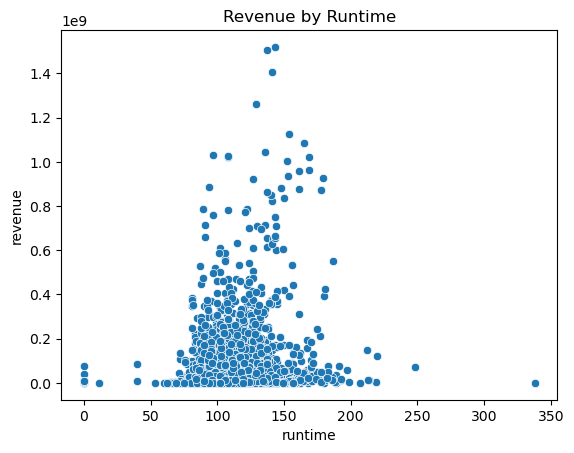

In [95]:
sns.scatterplot(x = "runtime", y = "revenue", data = df[df["data"] == "train"])
plt.title("Revenue by Runtime")
plt.show()

Mostly, Runtime is between 50 to 150. Some of them are 0. We should look at this films

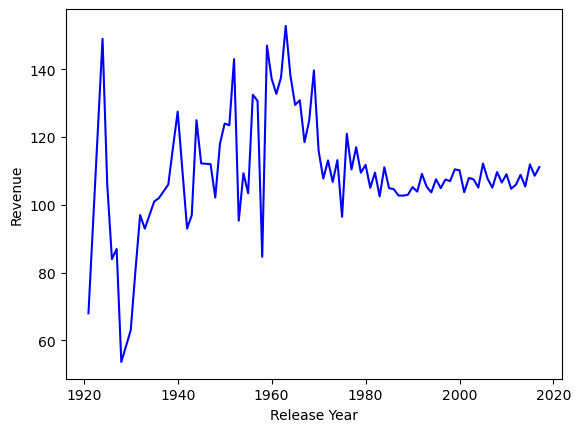

In [96]:
df.loc[df["data"] == "train"].groupby(by = "year")["runtime"].mean().plot(color = "b")
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.show()

As we get closer to the present, it seems that a standard has been achieved in the duration of the films.

## spoken_languages

In [97]:
df["spoken_languages"].head(10)

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5             [{'iso_639_1': 'en', 'name': 'English'}]
6             [{'iso_639_1': 'en', 'name': 'English'}]
7    [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...
8             [{'iso_639_1': 'en', 'name': 'English'}]
9             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, dtype: object

In [98]:
df.shape

(7398, 50)

I want to add number of languages spoken in movies

In [99]:
df["num_spoken_languages"] = df["spoken_languages"].apply(lambda x: len(get_dictionary(x)) if get_dictionary(x) != {} else 0 )

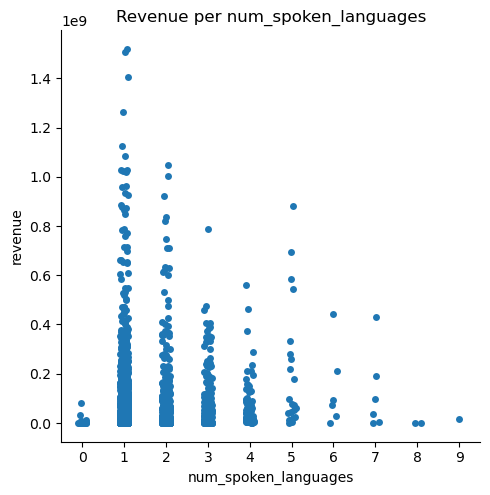

In [100]:
sns.catplot(x = "num_spoken_languages", y = "revenue", data = df[df["data"] == "train"])
plt.title("Revenue per num_spoken_languages")
plt.show()

As we see, movies which number of languages spoken is 1 more than others.   

In [101]:
list_spoken_languages = list(df['spoken_languages']. \
                         apply(lambda x: [i['iso_639_1'] for i in get_dictionary(x)] if x != {} \
                               else []).values)

In [102]:
element_frequencies_spoken_languages = Counter([language for languages in list_spoken_languages for language in languages]).most_common(15)

In [103]:
elements = [element for element, frequency in element_frequencies_spoken_languages]

In [104]:
df["spoken_languages"] = df["spoken_languages"].apply(lambda x: [language["iso_639_1"] for language in get_dictionary(x)] if x != {} else []). \
                                                apply(lambda x: ",".join(map(str,x)))

In [105]:
for element in elements:
    df[f"spoken_language_{element}"] = df["spoken_languages"].apply(lambda x: 1 if element in x else 0)

In [106]:
spoken_language_cols = df.columns[-15:]

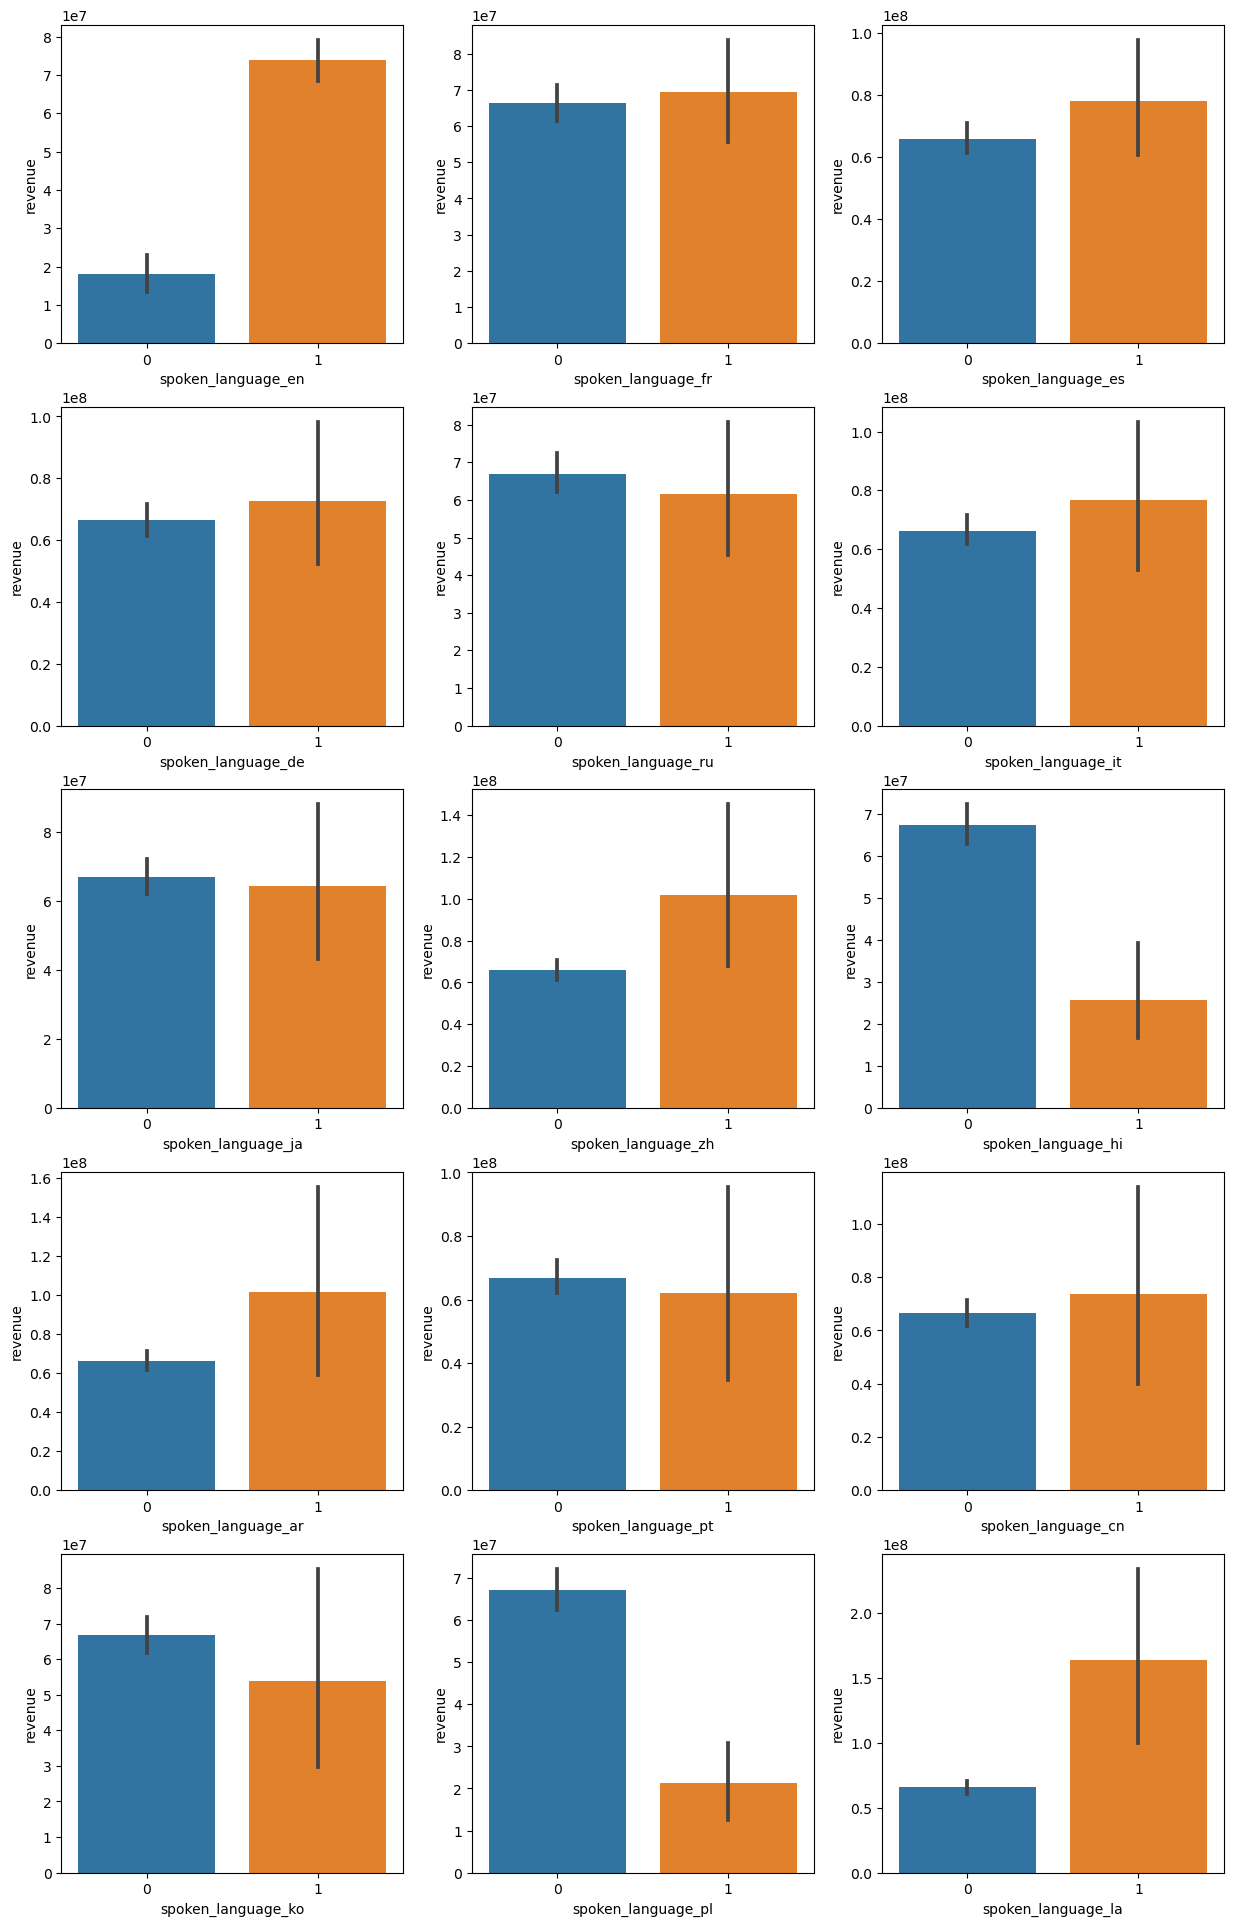

In [107]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (15, 24))
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.barplot(data=df[df["data"] == "train"], x=spoken_language_cols[i], y='revenue', ax = ax)
plt.show()

In [108]:
df = df.drop("spoken_languages", axis = 1)

## status feature

In [109]:
df[df["data"] == "train"].status.value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

There are 4 movies with rumored status. Now, look at revenue of this movies.

In [110]:
df.loc[(df["data"] == "train") & (df["status"] == "Rumored"), "revenue"]

609       273644.0
1007          60.0
1216    13418091.0
1618      229000.0
Name: revenue, dtype: float64

Movies with rumored status has a revenue. This is weird.

In [111]:
df[df["data"] == "test"].status.value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

I am gonna drop movies with rumored status

In [112]:
df = df.drop("status", axis = 1)

## tagline feature

In [113]:
df["tagline"].head()

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
Name: tagline, dtype: object

In [114]:
df["tagline"].info()

<class 'pandas.core.series.Series'>
Int64Index: 7398 entries, 0 to 4397
Series name: tagline
Non-Null Count  Dtype 
--------------  ----- 
5938 non-null   object
dtypes: object(1)
memory usage: 115.6+ KB


Some of movies has tagline, some of them not. I am gonna do feature engineering with this knowledge

In [115]:
df["has_tagline"] = 1
df.loc[df["tagline"].isnull(), "has_tagline"] = 0

In [116]:
df.has_tagline.value_counts()

1    5938
0    1460
Name: has_tagline, dtype: int64

Works which we did is proper.

In [117]:
df = df.drop("tagline", axis = 1)

## title feature

In [118]:
df["title"].head()

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                  Marine Boy
Name: title, dtype: object

In [119]:
df["title"].info()

<class 'pandas.core.series.Series'>
Int64Index: 7398 entries, 0 to 4397
Series name: title
Non-Null Count  Dtype 
--------------  ----- 
7395 non-null   object
dtypes: object(1)
memory usage: 115.6+ KB


I am gonna add this feature to drop list. I cant think of anything about this feature 

In [120]:
df = df.drop("title", axis = 1)

## keywords feature

In [121]:
df["keywords"].head()

0    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
2    [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
3    [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
4                                                  NaN
Name: keywords, dtype: object

In [122]:
df["keywords"].info()

<class 'pandas.core.series.Series'>
Int64Index: 7398 entries, 0 to 4397
Series name: keywords
Non-Null Count  Dtype 
--------------  ----- 
6729 non-null   object
dtypes: object(1)
memory usage: 115.6+ KB


We can exrtact number of keywords. And after that we can find band for numbers of keywords.

In [123]:
df["num_keywords"] = df["keywords"].apply(lambda x: len(get_dictionary(x)) if x != {} else 0)

In [124]:
df["num_keywords_band"] = pd.qcut(df["num_keywords"], q = 5)

In [125]:
df[["num_keywords_band", "revenue"]].groupby(by = "num_keywords_band").mean().sort_values(by = "revenue", ascending = False)

,revenue
num_keywords_band,
"(11.0, 149.0]",1.099455e+08
"(7.0, 11.0]",9.609099e+07
"(5.0, 7.0]",7.307137e+07
"(2.0, 5.0]",4.711136e+07
"(-0.001, 2.0]",2.301787e+07


In [126]:
df.loc[df["num_keywords"] <= 2, "keywords"] = 1
df.loc[(df["num_keywords"] > 2) & (df["num_keywords"] <= 5), "keywords"] = 2
df.loc[(df["num_keywords"] > 5) & (df["num_keywords"] <= 7), "keywords"] = 3
df.loc[(df["num_keywords"] > 7) & (df["num_keywords"] <= 11), "keywords"] = 4
df.loc[(df["num_keywords"] > 11) & (df["num_keywords"] <= 149), "keywords"] = 5

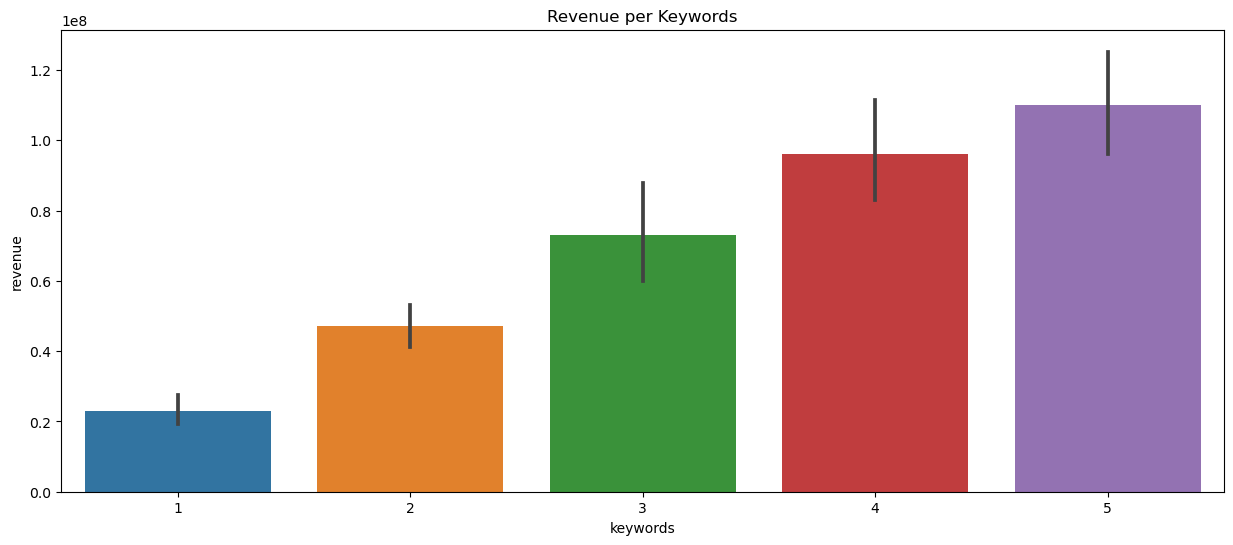

In [127]:
plt.figure(figsize = (15, 6))
sns.barplot(data = df[df["data"] == "train"], x = "keywords", y = "revenue")
plt.title("Revenue per Keywords")
plt.show()

In [128]:
df = df.drop(["num_keywords_band", "num_keywords"], axis = 1)

## cast feature

In [129]:
for i, e in enumerate(df['cast'][:1]):
    print(i, e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [130]:
df["num_cast"] = df["cast"].apply(lambda x: len(get_dictionary(x)) if x != {} else 0)

In [131]:
df["num_cast_band"] = pd.qcut(df["num_cast"], q = 5)

In [132]:
df[["num_cast_band", "revenue"]].groupby(by = "num_cast_band").mean().sort_values(by = "revenue", ascending = False)

,revenue
num_cast_band,
"(28.0, 165.0]",1.486214e+08
"(18.0, 28.0]",7.558689e+07
"(14.0, 18.0]",5.620282e+07
"(10.0, 14.0]",3.817828e+07
"(-0.001, 10.0]",2.286880e+07


In [133]:
df["cat_cast"] = 1
df.loc[df["num_cast"] <= 10, "cat_cast"] = 1
df.loc[(df["num_cast"] > 10) & (df["num_cast"] <= 14), "cat_cast"] = 2
df.loc[(df["num_cast"] > 14) & (df["num_cast"] <= 19), "cat_cast"] = 3
df.loc[(df["num_cast"] > 19) & (df["num_cast"] <= 28), "cat_cast"] = 4
df.loc[(df["num_cast"] > 28) & (df["num_cast"] <= 165), "cat_cast"] = 5

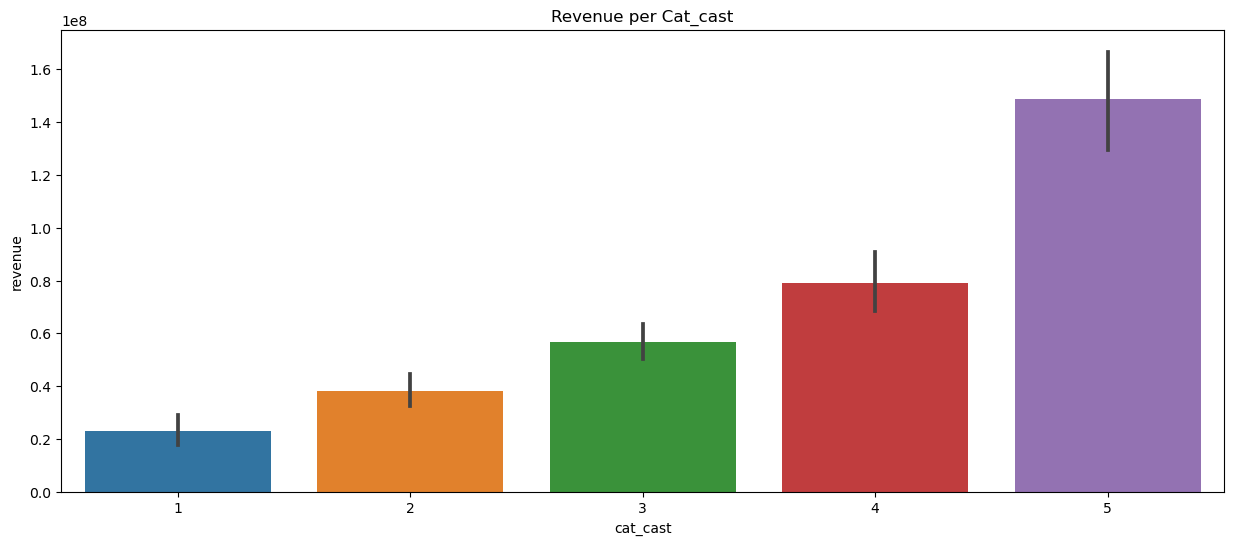

In [134]:
plt.figure(figsize = (15, 6))
sns.barplot(data = df[df["data"] == "train"], x = "cat_cast", y = "revenue")
plt.title("Revenue per Cat_cast")
plt.show()

Movies with less than 10 people in cast have the lowest revenue, but movies with more than 28 people in cast have highest revenue 

In [135]:
df = df.drop(["num_cast", "num_cast_band"], axis = 1)

Now, we can look at the number of films per actor and we can do feature enginnering with this knowledge

In [136]:
list_actor = list(df["cast"].apply(lambda x: [cast["name"] for cast in get_dictionary(x)] \
                                  if x != {} else []).values)

In [137]:
castedperson_frequency = Counter([castedperson for casteam in list_actor for castedperson in casteam]).most_common()

In [138]:
castedperson_frequency[:15]

[('Samuel L. Jackson', 80),
 ('Robert De Niro', 71),
 ('Bruce Willis', 62),
 ('Morgan Freeman', 61),
 ('Liam Neeson', 57),
 ('Willem Dafoe', 55),
 ('Steve Buscemi', 55),
 ('Sylvester Stallone', 54),
 ('Nicolas Cage', 54),
 ('Matt Damon', 51),
 ('J.K. Simmons', 50),
 ('John Goodman', 50),
 ('Julianne Moore', 50),
 ('Christopher Walken', 50),
 ('Robin Williams', 50)]

In [139]:
df["castedperson_name"] = df["cast"].apply(lambda x: [castedperson["name"] for castedperson in get_dictionary(x)] if get_dictionary(x) != {} else []). \
                                           apply(lambda x: ",".join(map(str, x)))

In [140]:
df["castedperson_name"].head()

0    Rob Corddry,Craig Robinson,Clark Duke,Adam Sco...
1    Anne Hathaway,Julie Andrews,H√©ctor Elizondo,J...
2    Miles Teller,J.K. Simmons,Melissa Benoist,Aust...
3    Vidya Balan,Nawazuddin Siddiqui,Parambrata Cha...
4    Kim Kang-woo,Jo Jae-hyeon,Park Si-yeon,Kim Joo...
Name: castedperson_name, dtype: object

In [141]:
df["mean_frequencyof_castedperson"] = df["castedperson_name"]. \
                     apply(lambda x: np.mean([freq for person, freq in castedperson_frequency if person in x])) 
                                        

In [142]:
df["mean_frequencyof_castedperson"].head()

0    9.480000
1    9.619048
2    3.563636
3    3.625000
4    2.250000
Name: mean_frequencyof_castedperson, dtype: float64

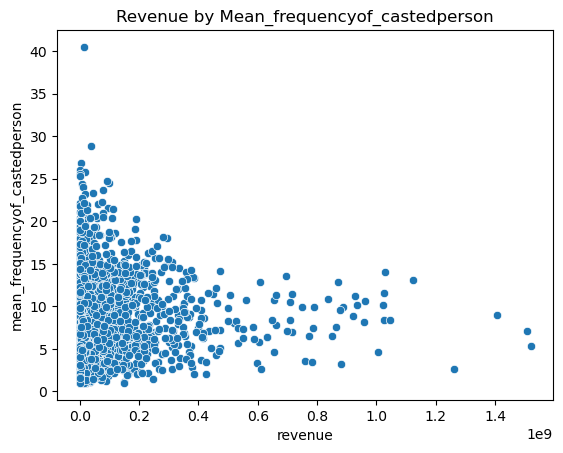

In [143]:
sns.scatterplot(data = df[df["data"] == "train"], y = "mean_frequencyof_castedperson", x = "revenue")
plt.title("Revenue by Mean_frequencyof_castedperson")
plt.show()

Now, I want to add binary variables which indicator for most common 15 castedperson

In [144]:
most_common_15 = Counter([castedperson for casteam in list_actor for castedperson in casteam]).\
                            most_common(15)

In [145]:
most_common_15

[('Samuel L. Jackson', 80),
 ('Robert De Niro', 71),
 ('Bruce Willis', 62),
 ('Morgan Freeman', 61),
 ('Liam Neeson', 57),
 ('Willem Dafoe', 55),
 ('Steve Buscemi', 55),
 ('Sylvester Stallone', 54),
 ('Nicolas Cage', 54),
 ('Matt Damon', 51),
 ('J.K. Simmons', 50),
 ('John Goodman', 50),
 ('Julianne Moore', 50),
 ('Christopher Walken', 50),
 ('Robin Williams', 50)]

In [146]:
for common_actor, freq in most_common_15:
    df[f"is_{common_actor}_play"] = df["castedperson_name"].apply(lambda x: 1 if common_actor in x.split(",") else 0)

In [147]:
df[df.columns[-15:]]

,is_Samuel L. Jackson_play,is_Robert De Niro_play,is_Bruce Willis_play,is_Morgan Freeman_play,is_Liam Neeson_play,is_Willem Dafoe_play,is_Steve Buscemi_play,is_Sylvester Stallone_play,is_Nicolas Cage_play,is_Matt Damon_play,is_J.K. Simmons_play,is_John Goodman_play,is_Julianne Moore_play,is_Christopher Walken_play,is_Robin Williams_play
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4395,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


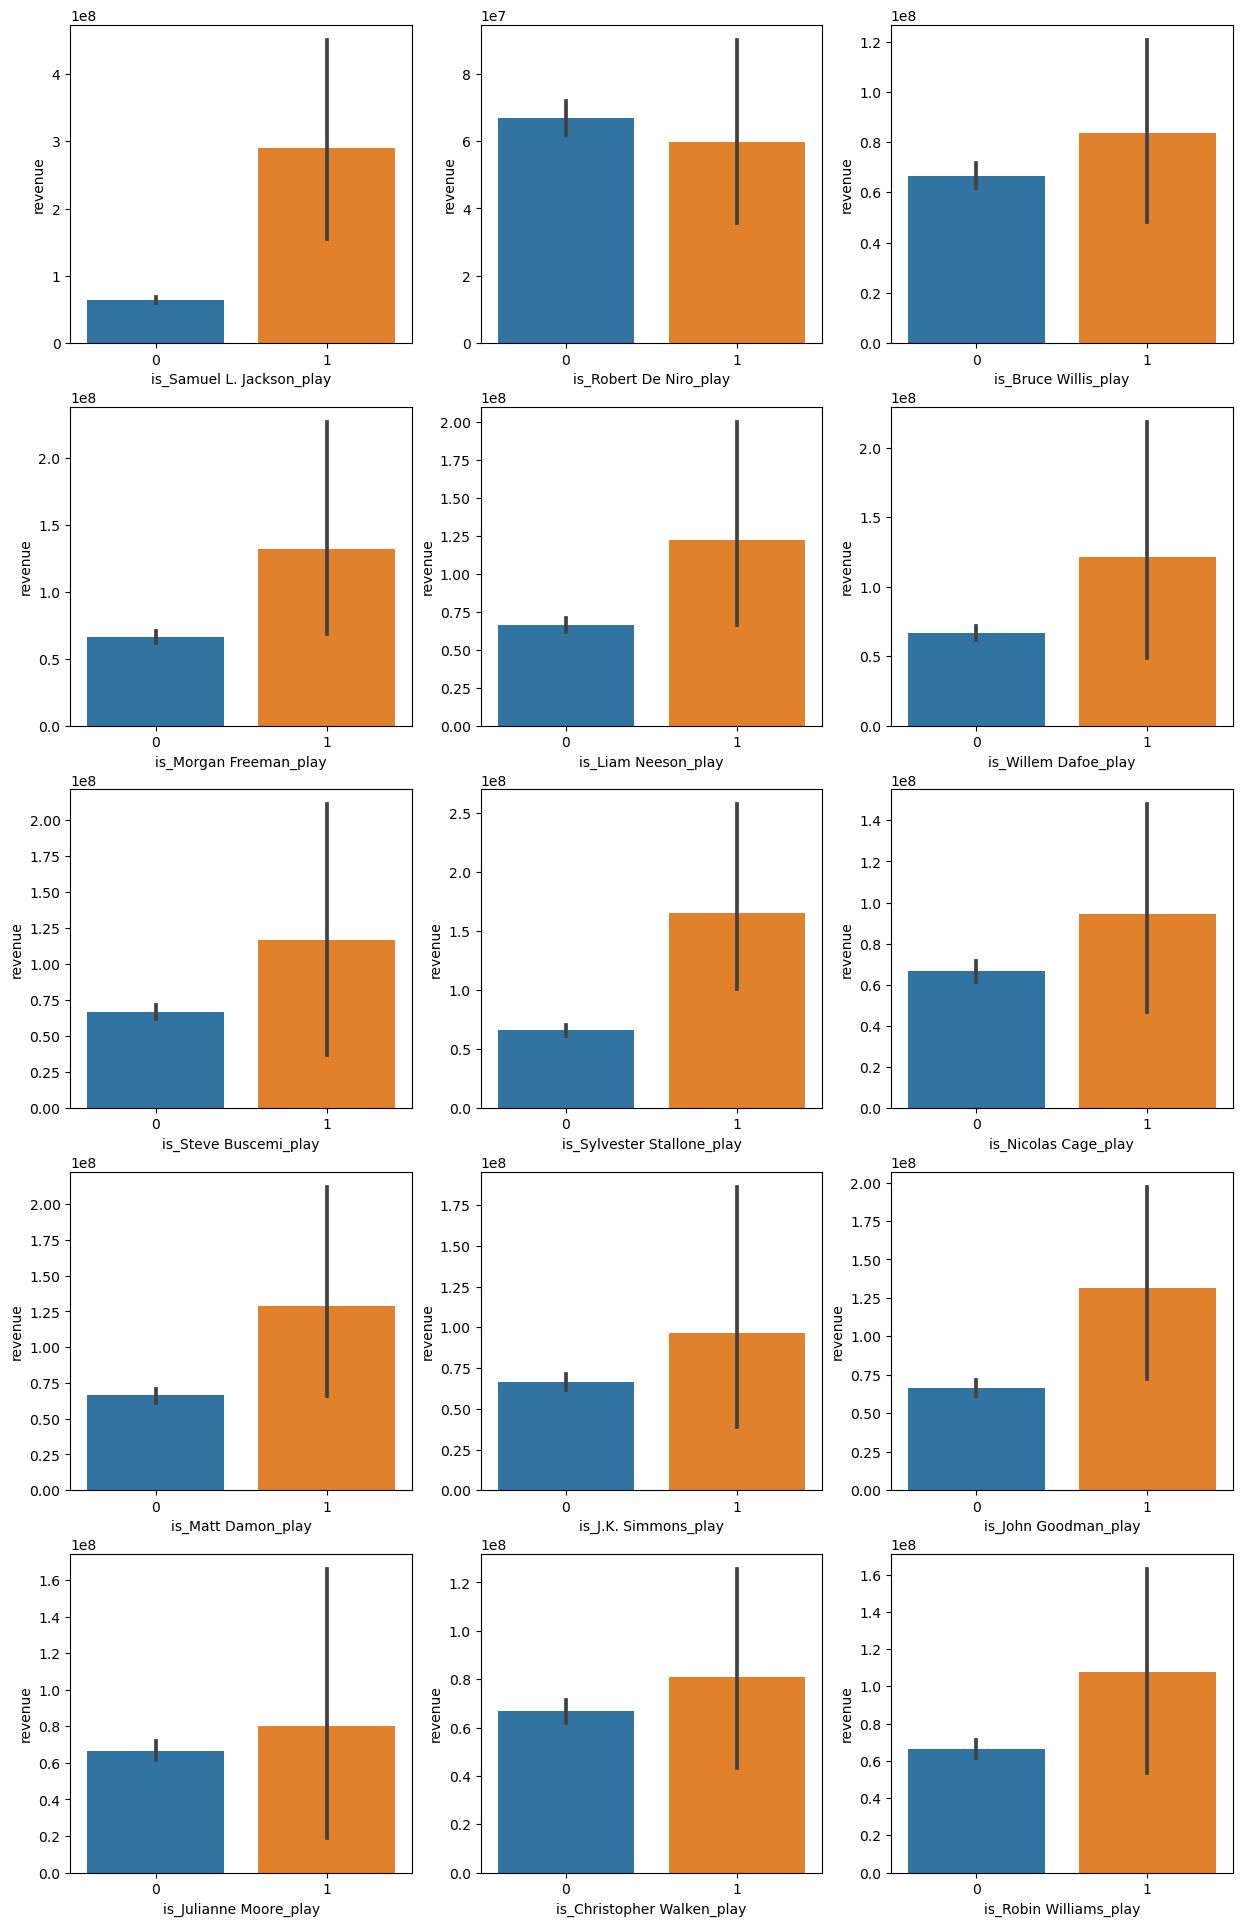

In [148]:
actor_cols = [col for col in df.columns if "play" in col]
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (15, 24))
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.barplot(data=df[df["data"] == "train"], x=actor_cols[i], y='revenue', ax = ax)
plt.show()

Except Robert De Niro, the actors have had a positive impact on the revenues of their films.

Now we can add castedperson's gender as a feature. Balance of gender can be important for the movies. There are 3 type gender which 0 is unspecified, 1 is female and 2 ise male. ((https://www.kaggle.com/c/tmdb-box-office-prediction/discussion/80983#475572))

In [149]:
df["gender_0_cast"] = df["cast"].apply(lambda x: sum([1 for i in get_dictionary(x) if i["gender"] == 0]) if x != {} else 0)
df["gender_1_cast"] = df["cast"].apply(lambda x: sum([1 for i in get_dictionary(x) if i["gender"] == 1]) if x != {} else 0)
df["gender_2_cast"] = df["cast"].apply(lambda x: sum([1 for i in get_dictionary(x) if i["gender"] == 2]) if x != {} else 0)

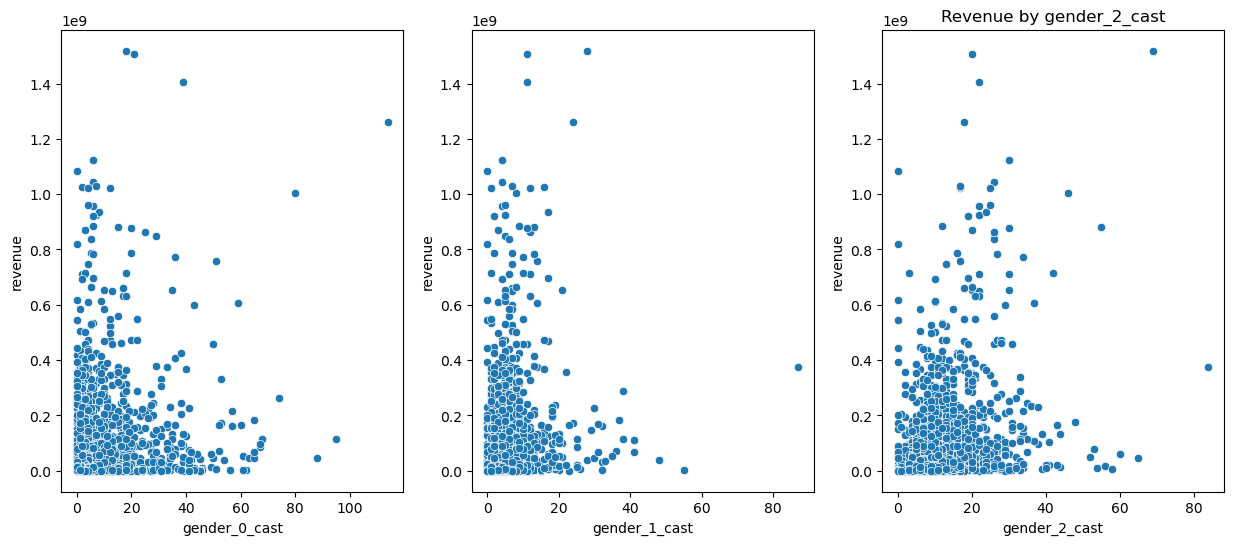

In [150]:
gender_cols = [col for col in df.columns if "gender_" in col]
fig, axes = plt.subplots(ncols = 3, figsize = (15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.scatterplot(data = df[df["data"] == "train"], x = gender_cols[i], y = "revenue", ax = ax)
    plt.title(f"Revenue by {gender_cols[i]}")
plt.show()

In [151]:
df = df.drop(["cast", "castedperson_name"], axis = 1)

## crew feature

In [152]:
for i, e in enumerate(df['crew'][:1]):
    print(i, e)

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

In movies, crew members is important as much as cast members. I want to divide crew members according to jobs. We can determine most 5 common persons according to jobs and using this knowledge we can do feature engineering

In [153]:
df["crew_name_job"] = df["crew"].apply(lambda x: [(crew["name"], crew["job"]) for crew in get_dictionary(x)] if x != {} else [])

In [154]:
for i, e in enumerate(df['crew_name_job'][:1]):
    print(i, e)

0 [('Kelly Cantley', 'First Assistant Director'), ('Steve Pink', 'Director'), ('Josh Heald', 'Writer'), ('Josh Heald', 'Characters'), ('Andrew Panay', 'Producer'), ('Adam Blum', 'Associate Producer'), ('Rob Corddry', 'Executive Producer'), ('Ben Ormand', 'Executive Producer'), ('Christophe Beck', 'Original Music Composer'), ('Declan Quinn', 'Director of Photography'), ('Jamie Gross', 'Editor'), ('Susie Farris', 'Casting'), ('Ryan Berg', 'Production Design'), ('Matt Moore', 'Executive Producer'), ('Nicole Garcea', 'Script Supervisor'), ('Jason Salzman', 'Production Coordinator'), ('Carol Cutshall', 'Costume Design'), ('Tim Cohn', 'Set Decoration'), ('Voni Hinkle', 'Hair Department Head'), ('Remi Savva', 'Makeup Department Head'), ('Jason Baldwin Stewart', 'Art Direction'), ('Korey Budd', 'Production Supervisor'), ('Gary C. Bourgeois', 'Sound Re-Recording Mixer'), ('Gabriel J. Serrano', 'Sound Re-Recording Mixer'), ('Victoria Rose Sampson', 'Dialogue Editor'), ('Michael B. Koff', 'Produc

In [155]:
list_of_crew_jobs = list(df['crew'].apply(lambda x: [i['job'] for i in get_dictionary(x)] if x != {} else []).values)
most_jobs = [i for i, j in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
most_jobs

['Producer',
 'Executive Producer',
 'Director',
 'Screenplay',
 'Editor',
 'Casting',
 'Director of Photography',
 'Original Music Composer',
 'Art Direction',
 'Production Design',
 'Costume Design',
 'Writer',
 'Set Decoration',
 'Makeup Artist',
 'Sound Re-Recording Mixer']

In [156]:
dict_jobs =  {}
for job in most_jobs:
    list_job = list(df["crew"].apply(lambda x: [crew["name"] for crew in get_dictionary(x) if crew["job"] == job] if x != {} else []).values)
    dict_jobs[job] = list_job

In [157]:
for job, people  in dict_jobs.items():
    person_frequency = Counter([person for i in people for person in i]).most_common(5)
    top_people = [person for person, freq in person_frequency]
    for top_person in top_people:
        df[f"is_{job}_{top_person}"] = df["crew"].apply(lambda x: 1 if len([True for i in get_dictionary(x) 
                                     if i["job"] == job and i["name"] == top_person] if x != {}
                                                                   else []) >= 1 else 0)

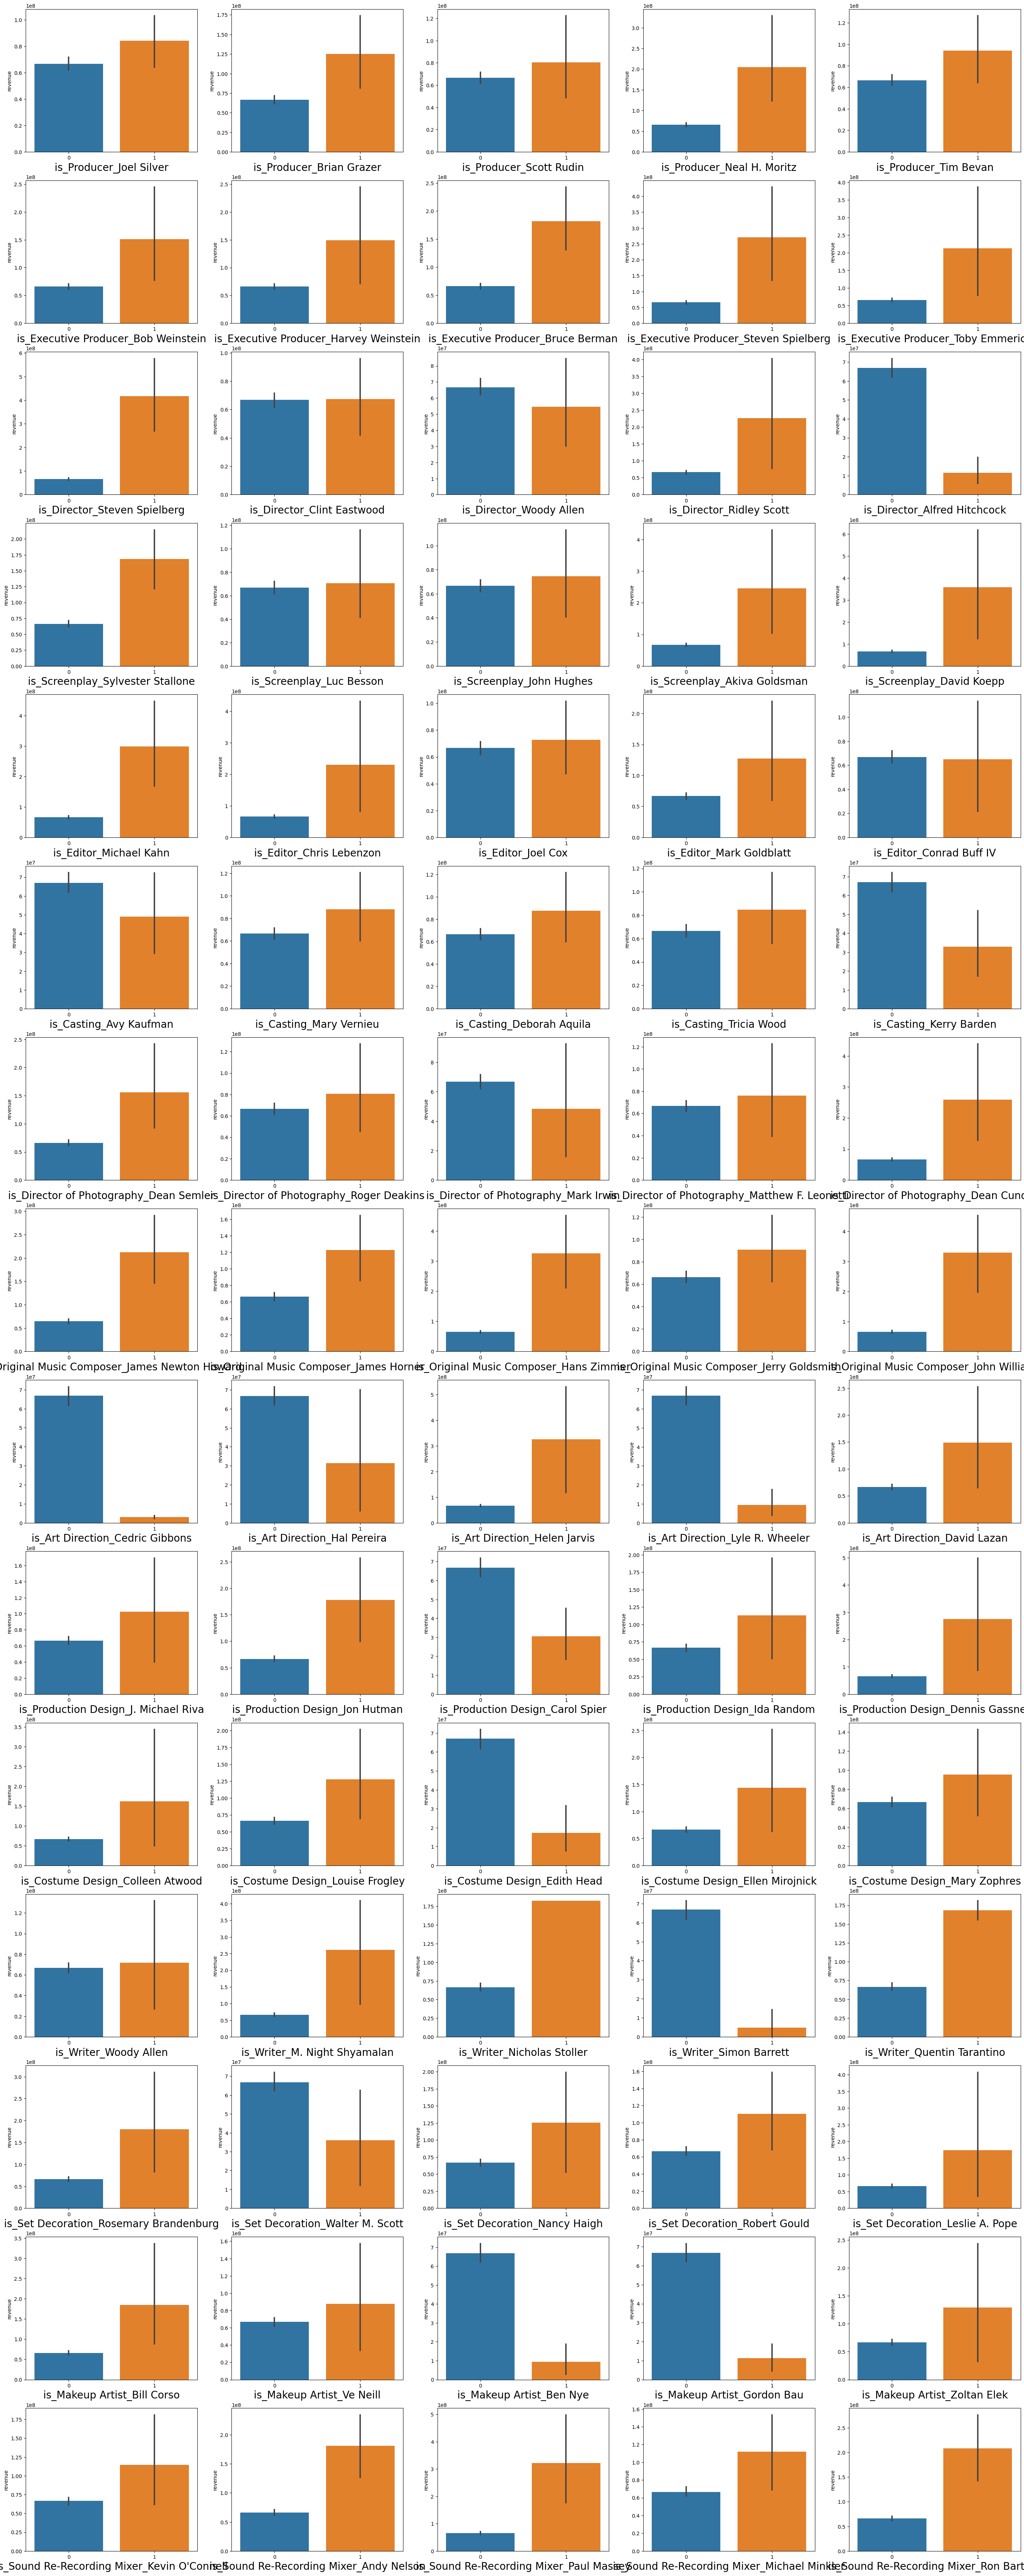

In [158]:
fig, axes = plt.subplots(nrows = 15, ncols = 5)
fig.set_size_inches(35, 90)
for i, jobs in enumerate(most_jobs):
    if i != 14:
        cols_job = list(df.columns[-75 + i * 5 : -70 + i * 5])
    else:
        cols_job = list(df.columns[-5:])
    for j, col in enumerate(cols_job):
        sns.barplot(data = df[df["data"] == "train"], x = col, y = "revenue", ax = axes[i,j])
        #axes[i, j].set_title(f"Revenue by {cols_job[j]}")
        axes[i, j].xaxis.label.set_fontsize(20)
plt.show()

In [159]:
df = df.drop(["crew_name_job", "crew"], axis = 1)

# Modeling

We are gonna predict log_revenue feature. After that we tranmsform log of revenue to original revenue feature.

In [160]:
nulls = pd.isnull(df[df["data"] == "train"])
nulls = nulls.sum()
nulls[nulls != 0]

overview                          8
runtime                           2
mean_frequencyof_castedperson    26
dtype: int64

In [161]:
nulls = pd.isnull(df[df["data"] == "test"])
nulls = nulls.sum()
nulls[nulls != 0]

overview                           14
runtime                             4
revenue                          4398
log_revenue                      4398
month                               1
year                                1
day                                 1
quarter                             1
weekofyear                          1
month_sin                           1
month_cos                           1
quarter_sin                         1
quarter_cos                         1
mean_frequencyof_castedperson      34
dtype: int64

In [162]:
df = df.fillna(0)

In [163]:
nulls = pd.isnull(df)
nulls = nulls.sum()
nulls[nulls != 0]

Series([], dtype: int64)

In [164]:
drop_list = []
drop_list.extend(["id", "revenue", "log_revenue"])
len(drop_list)

3

In [165]:
drop_list += list(df.select_dtypes(include=['object']).columns)
drop_list = list(set(drop_list))
drop_list = [col for col in drop_list if not "keywords" in col]

In [166]:
selected_columns = df.columns[~df.columns.isin(drop_list)]

In [167]:
df[selected_columns].head()

,budget,original_language,popularity,runtime,keywords,is_have_collection,is_have_homepage,Action,Adventure,Animation,...,is_Makeup Artist_Bill Corso,is_Makeup Artist_Ve Neill,is_Makeup Artist_Ben Nye,is_Makeup Artist_Gordon Bau,is_Makeup Artist_Zoltan Elek,is_Sound Re-Recording Mixer_Kevin O'Connell,is_Sound Re-Recording Mixer_Andy Nelson,is_Sound Re-Recording Mixer_Paul Massey,is_Sound Re-Recording Mixer_Michael Minkler,is_Sound Re-Recording Mixer_Ron Bartlett
0,14000000,10,6.575393,93.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40000000,10,8.248895,113.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3300000,10,64.299990,105.0,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200000,16,3.174936,122.0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,24,1.148070,118.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
cat_features_binary = []
for col in selected_columns:
    if df[col].nunique() == 2:
        cat_features_binary.append(col)
cat_features_date = ["month",
                     "year",
                     "day",
                     "quarter",
                     "weekofyear"]

df[cat_features_date] = df[cat_features_date].astype(int)
cat_features = cat_features_date + cat_features_binary + ["keywords", "cat_cast"]

for col in cat_features:
    df[col] = df[col].astype('category')

In [169]:
train = df[df["data"] == "train"]
test = df[df["data"] == "test"]

In [170]:
train.shape, test.shape

((3000, 156), (4398, 156))

In [171]:
# I got this codes from https://www.kaggle.com/code/kamalchhirang/
# eda-feature-engineering-lgb-xgb-cat#Feature-Engineering-&-Prediction
# Clean Data
train.loc[train['id'] == 16,'revenue'] = 192864          # Skinning
train.loc[train['id'] == 90,'budget'] = 30000000         # Sommersby          
train.loc[train['id'] == 118,'budget'] = 60000000        # Wild Hogs
train.loc[train['id'] == 149,'budget'] = 18000000        # Beethoven
train.loc[train['id'] == 313,'revenue'] = 12000000       # The Cookout 
train.loc[train['id'] == 451,'revenue'] = 12000000       # Chasing Liberty
train.loc[train['id'] == 464,'budget'] = 20000000        # Parenthood
train.loc[train['id'] == 470,'budget'] = 13000000        # The Karate Kid, Part II
train.loc[train['id'] == 513,'budget'] = 930000          # From Prada to Nada
train.loc[train['id'] == 797,'budget'] = 8000000         # Welcome to Dongmakgol
train.loc[train['id'] == 819,'budget'] = 90000000        # Alvin and the Chipmunks: The Road Chip
train.loc[train['id'] == 850,'budget'] = 90000000        # Modern Times
train.loc[train['id'] == 1007,'budget'] = 2              # Zyzzyx Road 
train.loc[train['id'] == 1112,'budget'] = 7500000        # An Officer and a Gentleman
train.loc[train['id'] == 1131,'budget'] = 4300000        # Smokey and the Bandit   
train.loc[train['id'] == 1359,'budget'] = 10000000       # Stir Crazy 
train.loc[train['id'] == 1542,'budget'] = 1              # All at Once
train.loc[train['id'] == 1570,'budget'] = 15800000       # Crocodile Dundee II
train.loc[train['id'] == 1571,'budget'] = 4000000        # Lady and the Tramp
train.loc[train['id'] == 1714,'budget'] = 46000000       # The Recruit
train.loc[train['id'] == 1721,'budget'] = 17500000       # Cocoon
train.loc[train['id'] == 1865,'revenue'] = 25000000      # Scooby-Doo 2: Monsters Unleashed
train.loc[train['id'] == 1885,'budget'] = 12             # In the Cut
train.loc[train['id'] == 2091,'budget'] = 10             # Deadfall
train.loc[train['id'] == 2268,'budget'] = 17500000       # Madea Goes to Jail budget
train.loc[train['id'] == 2491,'budget'] = 6              # Never Talk to Strangers
train.loc[train['id'] == 2602,'budget'] = 31000000       # Mr. Holland's Opus
train.loc[train['id'] == 2612,'budget'] = 15000000       # Field of Dreams
train.loc[train['id'] == 2696,'budget'] = 10000000       # Nurse 3-D
train.loc[train['id'] == 2801,'budget'] = 10000000       # Fracture
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9               # Death at a Funeral
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000




#Clean Data
test.loc[test['id'] == 6733,'budget'] = 5000000
test.loc[test['id'] == 3889,'budget'] = 15000000
test.loc[test['id'] == 6683,'budget'] = 50000000
test.loc[test['id'] == 5704,'budget'] = 4300000
test.loc[test['id'] == 6109,'budget'] = 281756
test.loc[test['id'] == 7242,'budget'] = 10000000
test.loc[test['id'] == 7021,'budget'] = 17540562       #  Two Is a Family
test.loc[test['id'] == 5591,'budget'] = 4000000        # The Orphanage
test.loc[test['id'] == 4282,'budget'] = 20000000       # Big Top Pee-wee
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

In [172]:
X = train[selected_columns]
y = train.revenue
X_test = test[selected_columns]
y_test = test.revenue

In [173]:
X.shape, X_test.shape

((3000, 151), (4398, 151))

In [174]:
params = {'learning_rate': 0.03,
          'objective':'MAE',
          'depth': 6,
          'early_stopping_rounds':1000,
          'iterations': 10000,
          'use_best_model': True,
          'eval_metric': "MAPE",
          'random_state': 986,
          'allow_writing_files': False,
          'thread_count':24
          }

In [175]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the mean absolute percentage error (MAPE).
    
    Parameters:
    - y_true: Array-like of shape (n_samples,), representing the true target values.
    - y_pred: Array-like of shape (n_samples,), representing the predicted values.
    
    Returns:
    - mape: Mean absolute percentage error.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true)
    
    # Calculate mean of absolute percentage error
    mape = np.mean(ape) * 100
    
    return mape

In [176]:
def catboost_trainer(X,
                     y,
                     submission_df,
                     cv,
                     model_params,
                     feature_list,
                     cat_features,
                     scorer,
                     target_transform=False):
    """
    Catboost Trainer.
    
    ---------
    :param X: training data
    :param y: target
    :param submission_df: test dataframe to be predicted
    :param cv: scikitlearn cross validation object
    :param model_params: dict of catboost model parameters
    :param feature_list: used list of features for training and inference
    :param cat_features: categorical features
    :param scorer: scikitlearn evaluation metric
    :param target_transform: Target
    :return: CV score list, models and submission predictions 
    """
    
    score_list = []
    fold = 1
    unseen_preds = []
    importance = []
    val_results = []
    train_results = []
    models = []
    
    for train_index, test_index in cv.split(X):
        X_train,X_val = X.iloc[train_index][feature_list],X.iloc[test_index][feature_list]
        y_train,y_val = y.iloc[train_index],y.iloc[test_index]
        sub_df_subset = submission_df[feature_list]
        print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")
        
        if target_transform:
            y_train = np.log1p(y_train)
            y_val = np.log1p(y_val)
        
        
        model = CatBoostRegressor(**model_params,
                                cat_features=cat_features
                               )
        model.fit(X_train,y_train,
                eval_set=[(X_val,y_val)],
                verbose=500)
        models.append(model)
        forecast_pred = model.predict(sub_df_subset)
        if target_transform:
            forecast_pred = np.expm1(forecast_pred)
        unseen_preds.append(forecast_pred)
        
        val_result = model.predict(X_val)
        if target_transform:
            val_result = np.expm1(val_result)
        
        train_result = model.predict(X_train)
        if target_transform:
            train_result = np.expm1(train_result)
            
        train_results.append(train_result)
        if target_transform:    
            y_train = np.expm1(y_train)
            y_val = np.expm1(y_val)
            
        score = np.sqrt(scorer(y_val,val_result))
        score_t = np.sqrt(scorer(y_train,train_result))
        
        print(f"Score Valid FOLD-{fold}:{score}")
        print(f"Score Train FOLD-{fold}:{score_t}")
        score_list.append(score)
        importance.append(model.get_feature_importance())
        fold += 1
        print('*'*50)
    print("Mean MAPE:", np.mean(score_list),"Std MAPE:",np.std(score_list))
    return score_list, models, unseen_preds

In [177]:
score_list, models, unseen_preds = catboost_trainer(X=X,
                                                  y=y,
                                                  submission_df= df[df["data"] == "test"],
                                                  cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                                  model_params=params,
                                                  feature_list=selected_columns,
                                                  cat_features=cat_features,
                                                  scorer=mean_absolute_percentage_error,
                                                  target_transform=True)

Training data shape: (2400, 151), Validation data shape: (600, 151)


TBB Warning: The number of workers is currently limited to 3. The request for 23 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.2366704	test: 0.2023671	best: 0.2023671 (0)	total: 66.4ms	remaining: 11m 4s
500:	learn: 0.1373917	test: 0.1269781	best: 0.1269744 (499)	total: 4.18s	remaining: 1m 19s
1000:	learn: 0.1137906	test: 0.1232951	best: 0.1232347 (930)	total: 8.49s	remaining: 1m 16s
1500:	learn: 0.1013685	test: 0.1217580	best: 0.1216087 (1465)	total: 12.8s	remaining: 1m 12s
2000:	learn: 0.0921218	test: 0.1209488	best: 0.1208972 (1994)	total: 17.2s	remaining: 1m 8s
2500:	learn: 0.0830775	test: 0.1193986	best: 0.1193790 (2443)	total: 22s	remaining: 1m 5s
3000:	learn: 0.0724067	test: 0.1167946	best: 0.1167946 (3000)	total: 26.5s	remaining: 1m 1s
3500:	learn: 0.0668556	test: 0.1162685	best: 0.1161674 (3428)	total: 30.9s	remaining: 57.3s
4000:	learn: 0.0616808	test: 0.1154779	best: 0.1154580 (3967)	total: 35.4s	remaining: 53s
4500:	learn: 0.0581579	test: 0.1154310	best: 0.1154270 (4496)	total: 39.8s	remaining: 48.7s
5000:	learn: 0.0556782	test: 0.1153184	best: 0.1153115 (4982)	total: 44.4s	remaining: 44

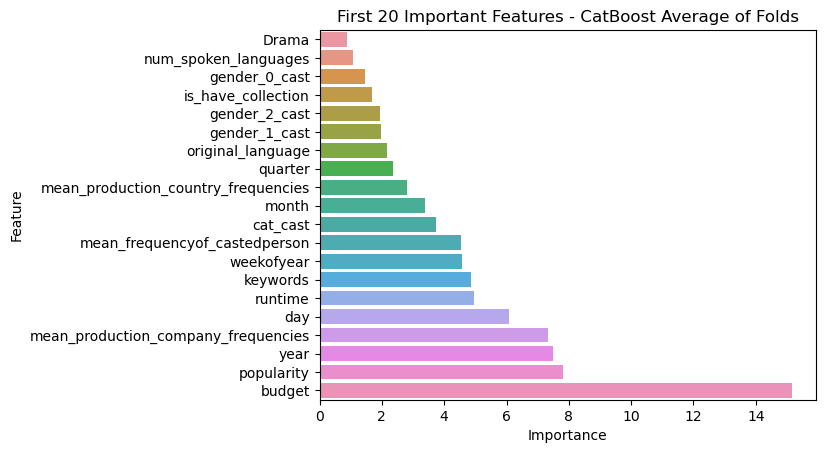

In [178]:
importance = [model.get_feature_importance() for model in models]

f_importance = pd.concat([pd.Series(X[selected_columns].columns.to_list(),name='Feature'),
                          pd.Series(np.mean(importance,axis=0),name="Importance")],
                         axis=1).sort_values(by='Importance',
                                             ascending=True)

sns.barplot(f_importance.tail(20),x='Importance',y='Feature')
plt.title("First 20 Important Features - CatBoost Average of Folds")

plt.show()

In [179]:
sub = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
sub["revenue"] = np.mean(unseen_preds, axis = 0)

In [180]:
sub.head()

,id,revenue
0,3001,1.086057e+07
1,3002,5.810964e+05
2,3003,1.342513e+07
3,3004,4.816756e+06
4,3005,4.255796e+05


In [181]:
sub.to_csv("submission.csv", index = False)